# Data Cleaning

In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version
import warnings;   warnings.filterwarnings("ignore")

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.10"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.10"):
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.22.4", 'matplotlib': "3.5.2",'sklearn': "1.1.1", 
                'pandas': "1.4.2",'xgboost': "1.5.1", 'shap': "0.40.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.10.5

[ OK ] numpy version 1.22.4 is installed.
[ OK ] matplotlib version 3.5.2 is installed.
[ OK ] sklearn version 1.1.1 is installed.
[ OK ] pandas version 1.4.2 is installed.
[ OK ] xgboost version 1.5.1 is installed.
[ OK ] shap version 0.40.0 is installed.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from itertools import accumulate
import six
nan = np.nan

fantasy_21_raw = pd.read_csv ('../data/fantasy_21.csv')
fantasy_22_raw = pd.read_csv ('../data/fantasy_22.csv')
teams_fifa_21_raw = pd.read_csv ('../data/teams_fifa22.csv')
teams_fifa_22_raw = pd.read_csv ('../data/teams_fifa23.csv')
matches_21_raw = pd.read_csv ('../data/matches_21.csv')
matches_22_raw = pd.read_csv ('../data/matches_22.csv')

In [3]:
#creates matches_21 dataset (contains all matches from 2021 season)
matches_21 = matches_21_raw[["Date", "Time","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_21 = matches_21.assign(HICT="")
matches_21 = matches_21.assign(AICT="")
matches_21.sort_index(inplace=True)
matches_21 = matches_21.reset_index(drop=True)

In [4]:
#creates fifa 21 dataset
fifa_21 = teams_fifa_21_raw[['Name','Overall']]
fifa_21 = fifa_21.head(20)
fifa_21 = fifa_21.sort_values(['Name'])
fifa_21['Overall'] = fifa_21['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_21_away = fifa_21.Overall.to_list()
overall_21_home = fifa_21.Overall.to_list()

In [5]:
#creates fifa 22 dataset
fifa_22 = teams_fifa_22_raw[['Name','Overall']]
fifa_22 = fifa_22.head(21)
fifa_22 = fifa_22[fifa_22.Name != 'AFC Richmond'].reset_index(drop = True)
fifa_22 = fifa_22.replace('AFC Bournemouth', 'Bournemouth')
fifa_22 = fifa_22.sort_values(['Name'])
fifa_22['Overall'] = fifa_22['Overall'].apply(lambda x: x*100)

#creates list of overall team scores 
overall_22_away = fifa_22.Overall.to_list()
overall_22_home = fifa_22.Overall.to_list()

In [6]:
#creates matches_22 dataset (contains all matches from 2022 season)
matches_22 = matches_22_raw[["Date", "GW","HomeTeam", "AwayTeam", "FTR", "Referee", "B365H", "B365D", "B365A"]]
matches_22 = matches_22.assign(HICT="")
matches_22 = matches_22.assign(AICT="")
matches_22.sort_index(inplace=True)
matches_22 = matches_22.reset_index(drop=True)

In [7]:
#creates ICT score dataset for 2021 season
fantasy_21_raw[['Date', 'Time']] = fantasy_21_raw['kickoff_time'].str.split('T', 1, expand=True)
fantasy_21 = fantasy_21_raw[["team", "ict_index", "Date", 'minutes']] 
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
fantasy_21 = fantasy_21.groupby(by=['team', 'Date'])['ict_index'].sum().to_frame()
ICT_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='ict_index').fillna(0)
ICT_2021.sort_index(inplace=True)
ICT_2021.reset_index(inplace=True)

In [8]:
#creates ICT score dataset for 2022 season
fantasy_22 = fantasy_22_raw[["team", "ict_index", "GW", 'minutes']]  
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
fantasy_22 = fantasy_22.groupby(by=['team', 'GW'])['ict_index'].sum().to_frame()
ICT_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='ict_index').fillna(0)
ICT_2022.sort_index(inplace=True)
ICT_2022.reset_index(inplace=True)

In [9]:
#creates boolean dataset showing when each team was home for 2021 season
fantasy_21 = fantasy_21_raw[["team", "was_home", "Date"]]
fantasy_21 = fantasy_21.sort_values(by=['team', 'Date'])
WH_2021 = fantasy_21.pivot_table(index=['team'], 
            columns=['Date'], values='was_home').fillna(0)
WH_2021.sort_index(inplace=True)
WH_2021.reset_index(inplace=True)

In [10]:
#creates boolean dataset showing when each team was home for 2022 season
fantasy_22 = fantasy_22_raw[["team", "was_home", "GW"]]
fantasy_22 = fantasy_22.sort_values(by=['team', 'GW'])
WH_2022 = fantasy_22.pivot_table(index=['team'], 
            columns=['GW'], values='was_home').fillna(0)
WH_2022.sort_index(inplace=True)
WH_2022.reset_index(inplace=True)

In [11]:
#helper funtions

#returns average of list
def Average(lst):
    return sum(lst) / len(lst)

#returns scores of each team
def get_score_21_away():
    empty_list_21 = []
    for score in overall_21_away:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_away.remove(score)
            return score

def get_score_22_away():
    empty_list_22 = []
    for score in overall_22_away:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_away.remove(score)
            return score
        
def get_score_21_home():
    empty_list_21 = []
    for score in overall_21_home:
        if score not in empty_list_21:
            empty_list_21.append(score)
            overall_21_home.remove(score)
            return score

def get_score_22_home():
    empty_list_22 = []
    for score in overall_22_home:
        if score not in empty_list_22:
            empty_list_22.append(score)
            overall_22_home.remove(score)
            return score

In [12]:
#sorts matches 21 dataset by date and awayteam and converts to datetime object
matches_21['Date'] = pd.to_datetime(matches_21['Date'], format='%m/%d/%y')
matches_21 = matches_21.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 21 with a mask of boolean was home dataset (away)
away_team_ict_21 = ICT_2021.mask(WH_2021 == 1.0)

#populates AICT column for Matches 21 dataframe
away_team_rows_21 =[]
if 'Away Team' in away_team_ict_21.columns:
    away_team_ict_21 = away_team_ict_21.drop('Away Team', axis=1)  
for index, rows in away_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    away_team_rows_21.append(my_list)
away_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_21]
away_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_21]

team_list_sum = []
for team in away_team_rows_21:
    team.insert(0, get_score_21_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))
flat_list_a21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a21.append(item)
matches_21 = matches_21.assign(AICT=flat_list_a21)

#combines matches 21 with a mask of boolean was home dataset (home)
home_team_ict_21 = ICT_2021.mask(WH_2021 == 0.0)

#populates HICT column for Matches 21 dataframe
matches_21 = matches_21.sort_values(['HomeTeam','Date']).reset_index(drop=True)
home_team_rows_21 = []
if 'Home Team' in home_team_ict_21.columns:
    home_team_ict_21 = home_team_ict_21.drop('Home Team', axis=1)  
for index, rows in home_team_ict_21.iterrows():
    my_list = [rows["2021-08-13"],rows["2021-08-14"],rows["2021-08-15"],rows["2021-08-21"],
               rows["2021-08-22"],rows["2021-08-23"],rows["2021-08-28"],rows["2021-08-29"],rows["2021-09-11"],
               rows["2021-09-12"],rows["2021-09-13"],rows["2021-09-17"],rows["2021-09-18"],rows["2021-09-19"],
               rows["2021-09-25"],rows["2021-09-26"],rows["2021-09-27"],rows["2021-10-02"],rows["2021-10-03"],
               rows["2021-10-16"],rows["2021-10-17"],rows["2021-10-18"],rows["2021-10-22"],rows["2021-10-23"],
               rows["2021-10-24"],rows["2021-10-30"],rows["2021-10-31"],rows["2021-11-01"],rows["2021-11-05"],
               rows["2021-11-06"],rows["2021-11-07"],rows["2021-11-20"],rows["2021-11-21"],rows["2021-11-27"],
               rows["2021-11-28"],rows["2021-11-30"],rows["2021-12-01"],rows["2021-12-02"],rows["2021-12-04"],
               rows["2021-12-05"],rows["2021-12-06"],rows["2021-12-10"],rows["2021-12-11"],rows["2021-12-12"],
               rows["2021-12-14"],rows["2021-12-15"],rows["2021-12-16"],rows["2021-12-18"],rows["2021-12-19"],
               rows["2021-12-26"],rows["2021-12-27"],rows["2021-12-28"],rows["2021-12-29"],rows["2021-12-30"],
               rows["2022-01-01"],rows["2022-01-02"],rows["2022-01-03"],rows["2022-01-11"],rows["2022-01-12"],
               rows["2022-01-14"],rows["2022-01-15"],rows["2022-01-16"],rows["2022-01-18"],rows["2022-01-19"],
               rows["2022-01-21"],rows["2022-01-22"],rows["2022-01-23"],rows["2022-02-05"],rows["2022-02-08"],
               rows["2022-02-09"],rows["2022-02-10"],rows["2022-02-12"],rows["2022-02-13"],rows["2022-02-15"],
               rows["2022-02-19"],rows["2022-02-20"],rows["2022-02-23"],rows["2022-02-24"],rows["2022-02-25"],
               rows["2022-02-26"],rows["2022-02-27"],rows["2022-03-01"],rows["2022-03-05"],rows["2022-03-06"],
               rows["2022-03-07"],rows["2022-03-10"],rows["2022-03-12"],rows["2022-03-13"],rows["2022-03-14"],
               rows["2022-03-16"],rows["2022-03-17"],rows["2022-03-18"],rows["2022-03-19"],rows["2022-03-20"],
               rows["2022-04-02"],rows["2022-04-03"],rows["2022-04-04"],rows["2022-04-06"],rows["2022-04-08"],
               rows["2022-04-09"],rows["2022-04-10"],rows["2022-04-16"],rows["2022-04-17"],rows["2022-04-19"],
               rows["2022-04-20"],rows["2022-04-21"],rows["2022-04-23"],rows["2022-04-24"],rows["2022-04-25"],
               rows["2022-04-28"],rows["2022-04-30"],rows["2022-05-01"],rows["2022-05-02"],rows["2022-05-07"],
               rows["2022-05-08"],rows["2022-05-10"],rows["2022-05-11"],rows["2022-05-12"],rows["2022-05-15"],
               rows["2022-05-16"],rows["2022-05-17"],rows["2022-05-19"], rows["2022-05-22"]]
    home_team_rows_21.append(my_list)
home_team_rows_21 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_21]
home_team_rows_21 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_21]

team_list_sum = []
for team in home_team_rows_21:
    team.insert(0, get_score_21_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h21 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h21.append(item)
matches_21 = matches_21.assign(HICT=flat_list_h21)

In [13]:
#sorts matches 22 dataset by date and converts to datetime object
matches_22['Date'] = pd.to_datetime(matches_22['Date'], format='%m/%d/%y')
matches_22 = matches_22.sort_values(['AwayTeam','Date']).reset_index(drop=True)

#combines matches 22 with a mask of boolean was home dataset (away)
away_team_ict_22 = ICT_2022.mask(WH_2022 == 1.0)
away_team_ict_22 = away_team_ict_22.rename({'team': 'Away Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1)

#populates AICT column for Matches 22 dataframe
away_team_rows_22 =[]
if 'Away Team' in away_team_ict_22.columns:
    away_team_ict_22 = away_team_ict_22.drop('Away Team', axis=1)  

for index, rows in away_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    away_team_rows_22.append(my_list)

away_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in away_team_rows_22]
away_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in away_team_rows_22]


team_list_sum = []
for team in away_team_rows_22:
    team.insert(0, get_score_22_away())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_a22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_a22.append(item)
matches_22 = matches_22.assign(AICT=flat_list_a22)

#combines matches 22 with a mask of boolean was home dataset (home)
home_team_ict_22 = ICT_2022.mask(WH_2022 == 0.0)
home_team_ict_22 = home_team_ict_22.rename({'team': 'Home Team', 1: 'GW1', 2: 'GW2', 3: 'GW3', 4: 'GW4', 
                            5: 'GW5', 6: 'GW6', 8: 'GW8', 9: 'GW9', 10: 'GW10'}, axis=1) 

#populates HICT column for Matches 22 dataframe
matches_22 = matches_22.sort_values(['HomeTeam','Date'])
home_team_rows_22 =[]
if 'Home Team' in home_team_ict_22.columns:
    home_team_ict_22.drop('Home Team', axis=1)  
for index, rows in home_team_ict_22.iterrows():
    my_list =[rows.GW1, rows.GW2, rows.GW3, rows.GW4, 
              rows.GW5, rows.GW6, rows.GW8, rows.GW9, rows.GW10]
    home_team_rows_22.append(my_list)
home_team_rows_22 = [[x for x in y if str(x) != 'nan'] for y in home_team_rows_22]
home_team_rows_22 = [[x for x in y if str(x) != '0.0'] for y in home_team_rows_22]

team_list_sum = []
for team in home_team_rows_22:
    team.insert(0, get_score_22_home())
    team.pop()
    team_list_sum.append(list(accumulate(team)))

flat_list_h22 = []
for sublist in team_list_sum:
    for item in sublist:
        flat_list_h22.append(item)
matches_22 = matches_22.assign(HICT=flat_list_h22)

In [57]:
#creates final dataset with cleaned data
#final_dataset = matches_21.append(matches_22).reset_index(drop = 'TRUE')
final_dataset = pd.concat([matches_21, matches_22]) 

final_dataset = final_dataset.sort_values(by='Date').reset_index(drop=True)
final_dataset = final_dataset.drop(['Time','GW'], axis=1)
final_dataset['DifICT'] = (final_dataset['HICT'] - final_dataset['AICT'])

if 'FTR' in final_dataset.columns:
    final_dataset['Result']=final_dataset['FTR']
    final_dataset = final_dataset.drop('FTR', axis=1)
    
#converts target variable to nominal data
final_dataset['Result'] = final_dataset['Result'].astype('category')
final_dataset['Result'].cat.categories = [0,1,2]
final_dataset['Result'] = final_dataset['Result'].astype('float')
date = final_dataset.copy()
if 'Date' in final_dataset.columns:
   final_dataset = final_dataset.drop('Date', axis=1)


ref_impact = final_dataset

if 'HomeTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('HomeTeam', axis=1)

if 'AwayTeam' in final_dataset.columns:
   final_dataset = final_dataset.drop('AwayTeam', axis=1)

final_dataset

Referee  B365H  B365D  B365A    HICT    AICT  DifICT  Result
0      M Oliver   4.00   3.40   1.95  7300.0  7900.0  -600.0     2.0
1      A Madley   1.90   3.50   4.00  7900.0  7600.0   300.0     2.0
2       D Coote   3.10   3.10   2.45  7600.0  7600.0     0.0     0.0
3        J Moss   1.25   5.75  13.00  8300.0  7600.0   700.0     2.0
4        M Dean   3.10   3.20   2.37  7500.0  7800.0  -300.0     2.0
..          ...    ...    ...    ...     ...     ...     ...     ...
452    M Oliver   2.50   3.60   2.62  8323.8  8698.8  -375.0     2.0
453   P Tierney   2.05   3.50   3.60  7795.1  7765.2    29.9     2.0
454  C Kavanagh   1.72   3.80   4.75  8176.2  7793.7   382.5     2.0
455     D Coote   3.60   3.50   2.05  8001.2  8402.0  -400.8     0.0
456    A Taylor   3.30   3.40   2.20  7796.1  8081.8  -285.7     1.0

[457 rows x 8 columns]

# EDA

In [58]:
#prints dtypes of all columns
pd.set_option('display.max_rows', 120)
final_dataset.dtypes

Referee     object
B365H      float64
B365D      float64
B365A      float64
HICT       float64
AICT       float64
DifICT     float64
Result     float64
dtype: object

In [59]:
#prints stats on target variable
final_dataset.Result.describe().to_frame().transpose()

count      mean       std  min  25%  50%  75%  max
Result  457.0  1.118162  0.863006  0.0  0.0  1.0  2.0  2.0

In [60]:
# Checking the missing values of all columns
final_dataset.isnull().sum()

Referee    0
B365H      0
B365D      0
B365A      0
HICT       0
AICT       0
DifICT     0
Result     0
dtype: int64

In [61]:
#value counts of target variable
final_dataset.Result.value_counts()
# 200/(200+146+111)



2.0    200
0.0    146
1.0    111
Name: Result, dtype: int64

In [62]:
#How many games each ref reffed
final_dataset.Referee.value_counts()

A Taylor        35
M Oliver        33
P Tierney       33
C Pawson        30
M Dean          25
M Atkinson      25
S Attwell       25
D Coote         24
J Moss          24
A Marriner      22
A Madley        22
S Hooper        21
C Kavanagh      19
D England       19
R Jones         17
K Friend        17
P Bankes        16
J Gillett       13
G Scott         13
J Brooks         8
M Salisbury      7
T Harrington     7
T Bramall        2
Name: Referee, dtype: int64

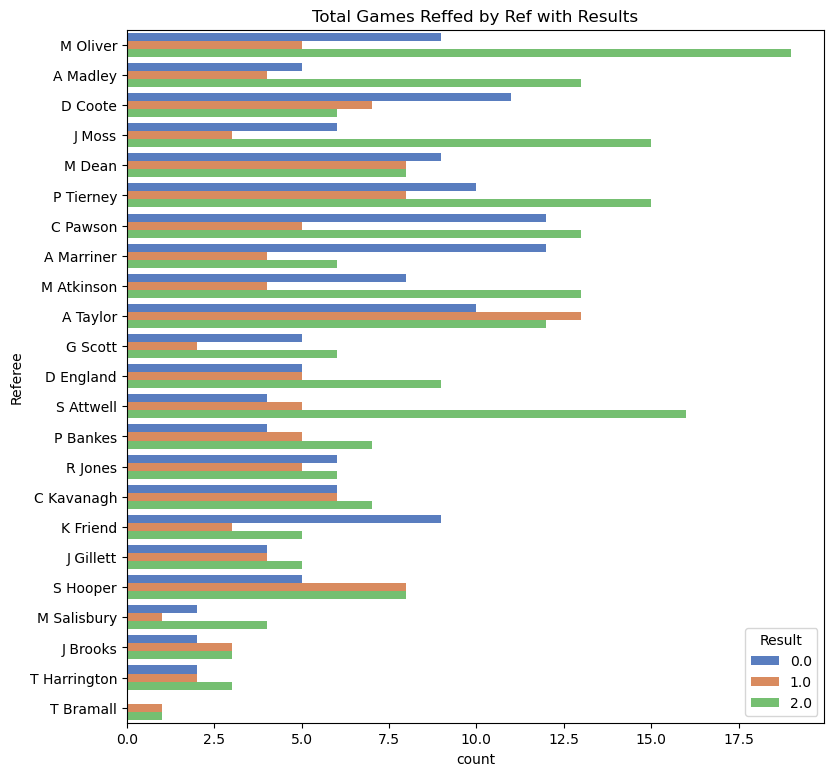

In [63]:
#Bar plot showing how many games each ref reffed
plt.figure(figsize=(9, 9))
sns.countplot(data = ref_impact, y="Referee", hue= 'Result', palette = 'muted')
plt.title("Total Games Reffed by Ref with Results")
plt.savefig(fname = '../figures/Total Games Reffed by Ref with Results', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [64]:
# percentage of value counts for target variable
final_dataset.Result.value_counts(normalize=True)

2.0    0.437637
0.0    0.319475
1.0    0.242888
Name: Result, dtype: float64

In [65]:
#stats for final_dataset
final_dataset.describe().round(2)

B365H   B365D   B365A     HICT     AICT   DifICT  Result
count  457.00  457.00  457.00   457.00   457.00   457.00  457.00
mean     3.03    4.24    4.66  8262.01  8226.76    35.24    1.12
std      2.32    1.45    4.39   505.94   496.46   590.51    0.86
min      1.06    2.80    1.14  7300.00  7300.00 -1473.20    0.00
25%      1.61    3.40    2.15  7891.30  7864.20  -354.40    0.00
50%      2.25    3.75    3.25  8198.50  8145.80    30.40    1.00
75%      3.40    4.50    5.50  8568.40  8515.20   415.00    2.00
max     19.00   13.00   29.00  9801.00  9809.20  1573.30    2.00

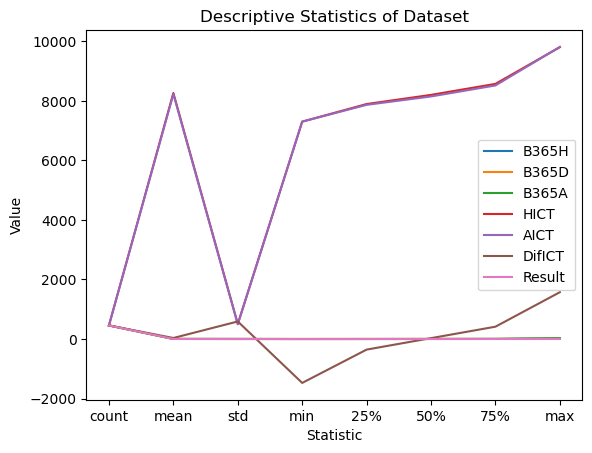

In [66]:
#stats for final_dataset plot
final_dataset.describe().round(2).plot()
plt.title("Descriptive Statistics of Dataset")
plt.ylabel("Value")
plt.xlabel("Statistic")
plt.savefig(fname = '../figures/Descriptive Statistics of Dataset', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [67]:
#info on final_dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Referee  457 non-null    object 
 1   B365H    457 non-null    float64
 2   B365D    457 non-null    float64
 3   B365A    457 non-null    float64
 4   HICT     457 non-null    float64
 5   AICT     457 non-null    float64
 6   DifICT   457 non-null    float64
 7   Result   457 non-null    float64
dtypes: float64(7), object(1)
memory usage: 28.7+ KB


In [68]:
#calculates correlation between Result and other values
correlation = final_dataset.corr().abs().unstack()
correlation = correlation.sort_values(ascending=False)
correlation.Result

Result    1.000000
DifICT    0.419218
B365H     0.412218
B365A     0.360987
AICT      0.256969
HICT      0.237133
B365D     0.169424
dtype: float64

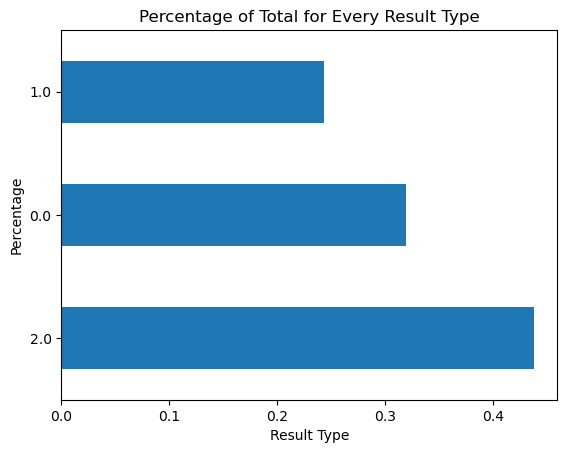

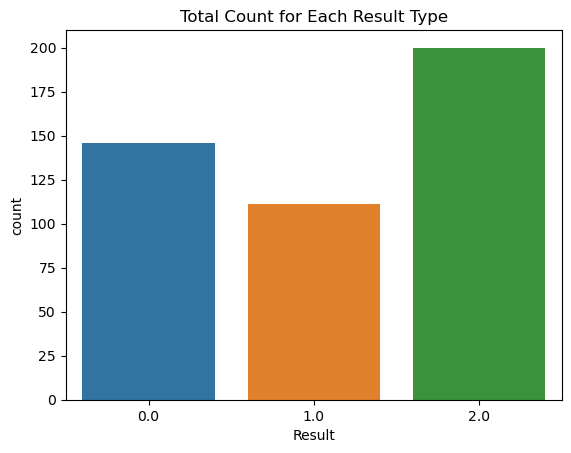

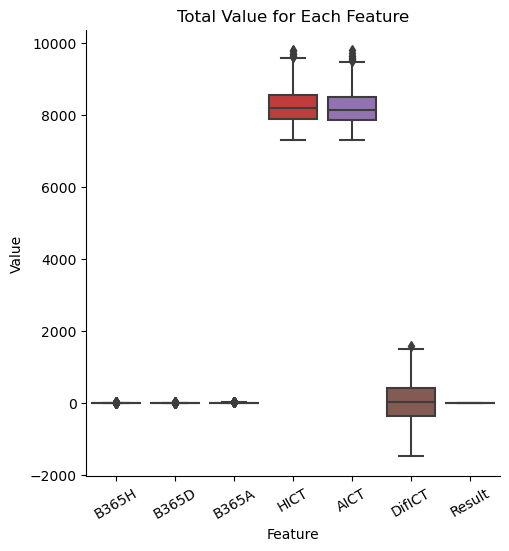

In [69]:
#count plots 
final_dataset.Result.value_counts(normalize=True).plot.barh()
plt.title("Percentage of Total for Every Result Type")
plt.savefig(fname = '../figures/Percentage of total for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.xlabel("Result Type")
plt.ylabel("Percentage")
plt.show()

count_plot = sns.countplot(x=final_dataset["Result"])
plt.title("Total Count for Each Result Type")
plt.savefig(fname = '../figures/Total Count for Each Result Type', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

fd_box = sns.catplot(data=final_dataset, kind="box")
fd_box.set_xticklabels(rotation=30)
plt.title("Total Value for Each Feature")
plt.ylabel("Value")
plt.xlabel("Feature")
plt.savefig(fname = '../figures/Total Value for Each Feature', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

In [70]:
#correlation between Result and specifc result outcomes
spearman = final_dataset[['Result', 'DifICT']].copy()
spearman['Home Wins']=(spearman['Result']==1.0).astype(int)
spearman['Away Wins']=(spearman['Result']==-1.0).astype(int)
spearman['Draw']=(spearman['Result']==0.0).astype(int)
my_r = spearman.corr(method="spearman")
print(my_r)

             Result    DifICT  Home Wins  Away Wins      Draw
Result     1.000000  0.406597  -0.124334        NaN -0.866223
DifICT     0.406597  1.000000  -0.003887        NaN -0.375703
Home Wins -0.124334 -0.003887   1.000000        NaN -0.388079
Away Wins       NaN       NaN        NaN        NaN       NaN
Draw      -0.866223 -0.375703  -0.388079        NaN  1.000000


In [71]:
spearman_noD = final_dataset[['Result', 'DifICT']].copy()
spearman_noD = spearman_noD[spearman_noD.Result != 0.0]
spearman_noD['Home Wins']=(spearman_noD['Result']==1.0).astype(int)
spearman_noD['Away wins']=(spearman_noD['Result']==-1.0).astype(int)
spearman_noD['Draw']=(spearman_noD['Result']==0.0).astype(int)
my_r = spearman_noD.corr(method="spearman")
print(my_r)

            Result   DifICT  Home Wins  Away wins  Draw
Result     1.00000  0.21377   -1.00000        NaN   NaN
DifICT     0.21377  1.00000   -0.21377        NaN   NaN
Home Wins -1.00000 -0.21377    1.00000        NaN   NaN
Away wins      NaN      NaN        NaN        NaN   NaN
Draw           NaN      NaN        NaN        NaN   NaN


In [72]:
spearman_win_draw = final_dataset[['Result', 'DifICT']].copy()
spearman_win_draw['Away Wins/Draws']=(spearman_win_draw['Result']!=1.0).astype(int)
spearman_win_draw['Home Wins/Draws']=(spearman_win_draw['Result']!=-1.0).astype(int)
my_r = spearman_win_draw.corr(method="spearman")
print(my_r)

                   Result    DifICT  Away Wins/Draws  Home Wins/Draws
Result           1.000000  0.406597         0.124334              NaN
DifICT           0.406597  1.000000         0.003887              NaN
Away Wins/Draws  0.124334  0.003887         1.000000              NaN
Home Wins/Draws       NaN       NaN              NaN              NaN


In [73]:
def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation - Result Types and DifICT")
    return(r)

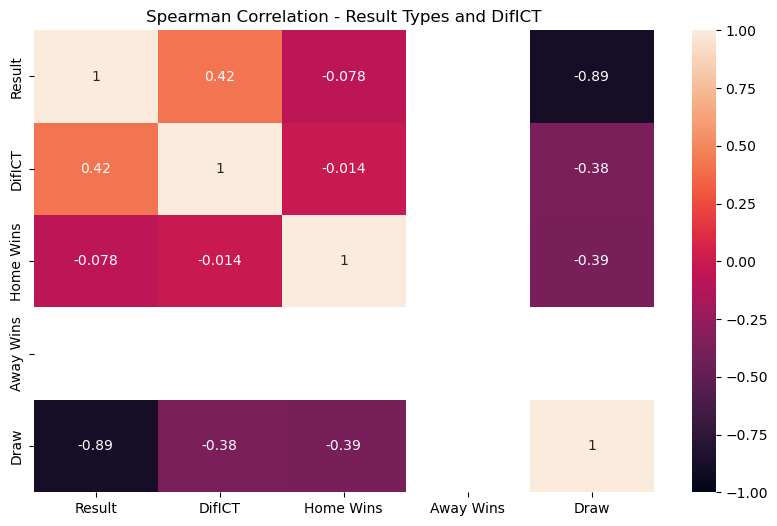

In [74]:
r_simple=display_correlation(spearman)
plt.savefig(fname = '../figures/Spearman Correlation', format = 'png', dpi = 300, bbox_inches='tight')

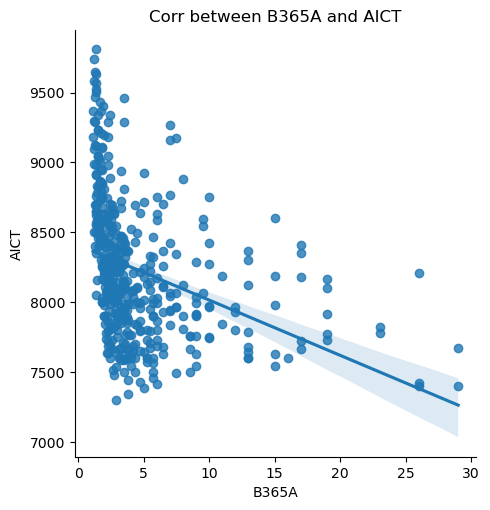

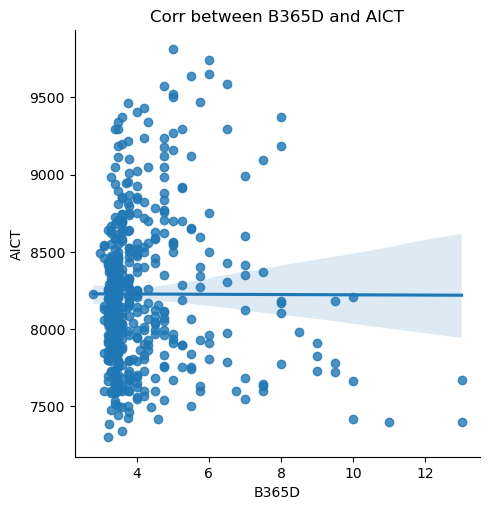

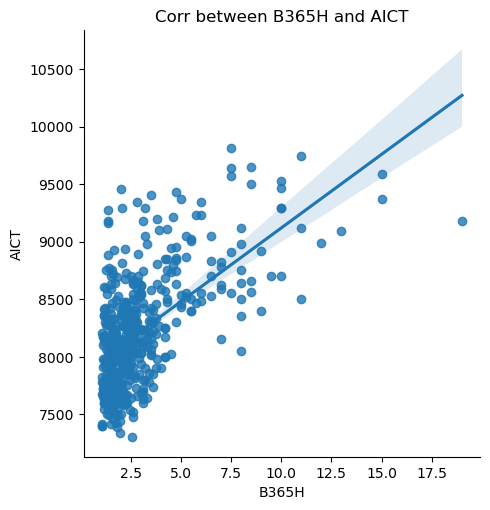

In [75]:
#scatter plots between odds and AICT
sns.lmplot(x='B365A',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and AICT")
plt.savefig(fname = '../figures/Corr between B365A and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and AICT")
plt.savefig(fname = '../figures/Corr between B365D and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365H',y='AICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and AICT")
plt.savefig(fname = '../figures/Corr between B365H and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

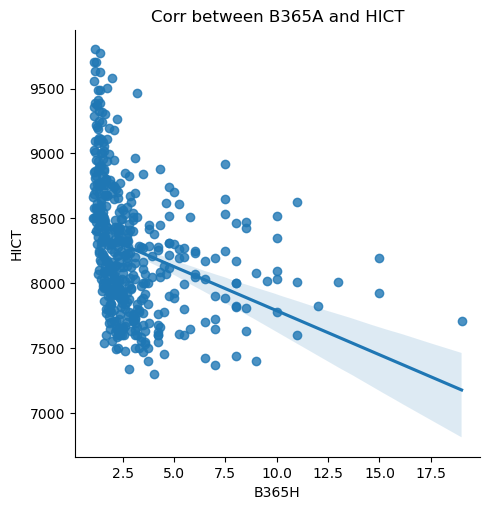

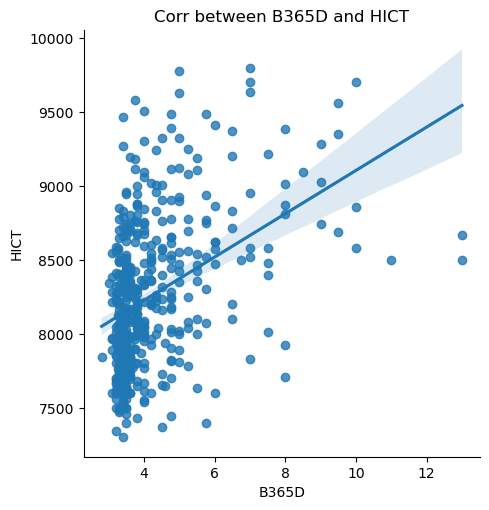

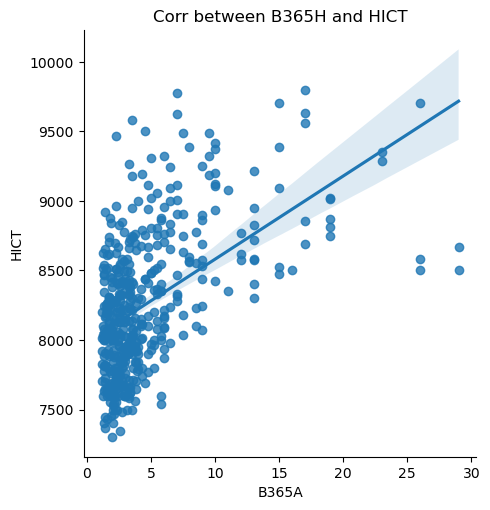

In [76]:
#scatter plots between odds and HICT
sns.lmplot(x='B365H',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and HICT")
plt.savefig(fname = '../figures/Corr between B365A and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and HICT")
plt.savefig(fname = '../figures/Corr between B365D and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='HICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and HICT")
plt.savefig(fname = '../figures/Corr between B365H and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

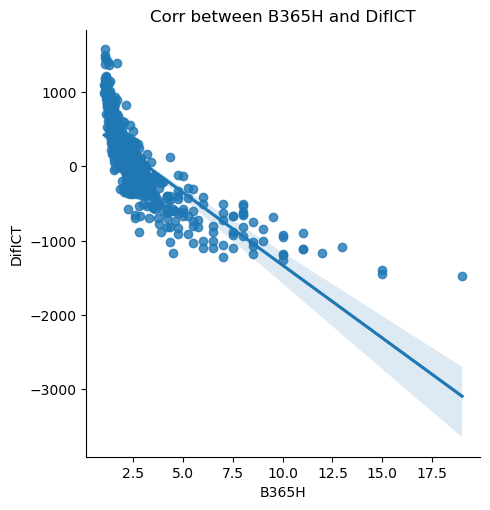

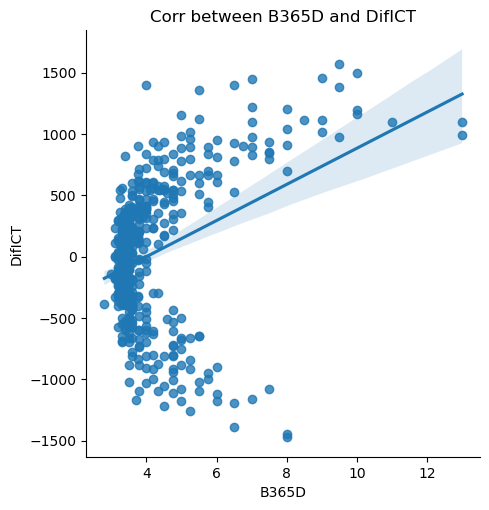

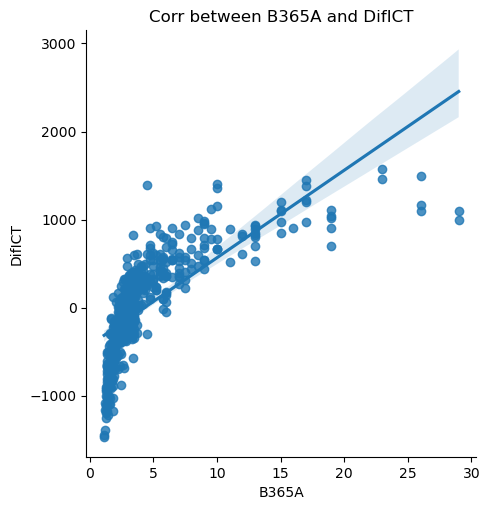

In [77]:
#scatter plots between odds and DifICT
sns.lmplot(x='B365H',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365H and DifICT")
plt.savefig(fname = '../figures/Corr between B365H and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365D',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365D and DifICT")
plt.savefig(fname = '../figures/Corr between B365D and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.lmplot(x='B365A',y='DifICT',data=final_dataset,fit_reg=True)
plt.title("Corr between B365A and DifICT")
plt.savefig(fname = '../figures/Corr between B365A and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

[ 0.99781182 -0.00707661  0.06121283 -0.06239719  0.04126072  0.00591132
  0.03895573  0.01011961 -0.04004851 -0.00469456]


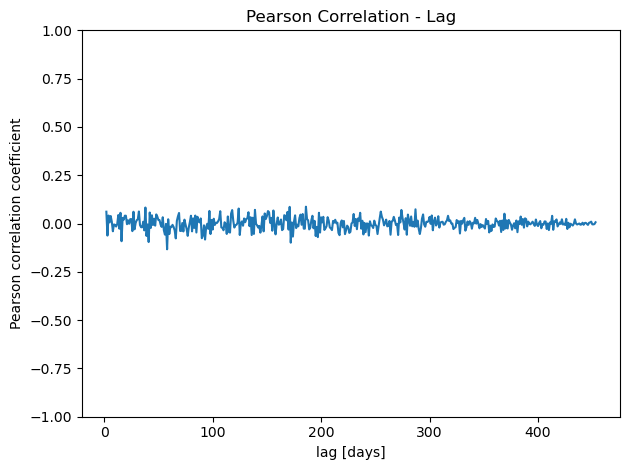

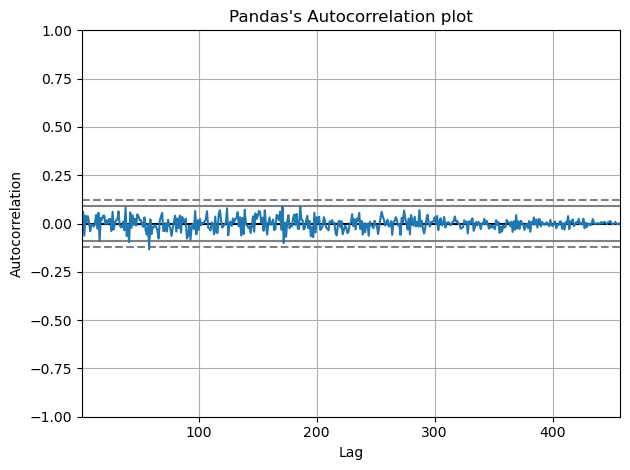

In [78]:
#auto correlation plot
lags = np.arange(457)
corr_coefs = np.zeros(457)

for i in np.arange(len(lags)):
    x = final_dataset['Result'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = final_dataset['Result'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/final_dataset['Result'].shape[0]
print(corr_coefs[:10])

pearson_corr_lag = plt.plot(lags[2:],corr_coefs[2:])
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('Pearson Correlation - Lag')
plt.tight_layout()
plt.savefig(fname = '../figures/Pearson Correlation - Lag', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

# a one-liner
panda_auto_corr = pd.plotting.autocorrelation_plot(final_dataset['Result'])
plt.title("Pandas's Autocorrelation plot")
plt.tight_layout()
plt.savefig(fname = '../figures/Pandas Autocorrelation plot', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

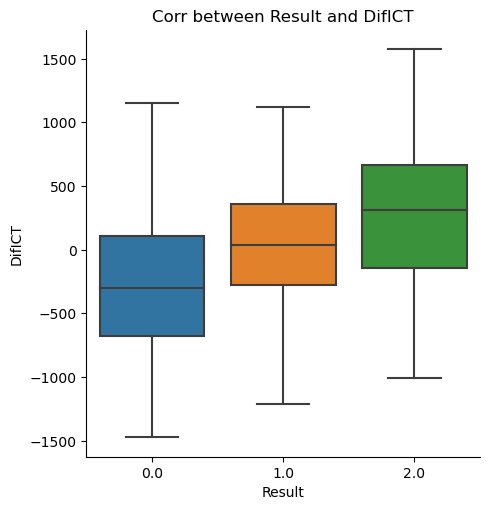

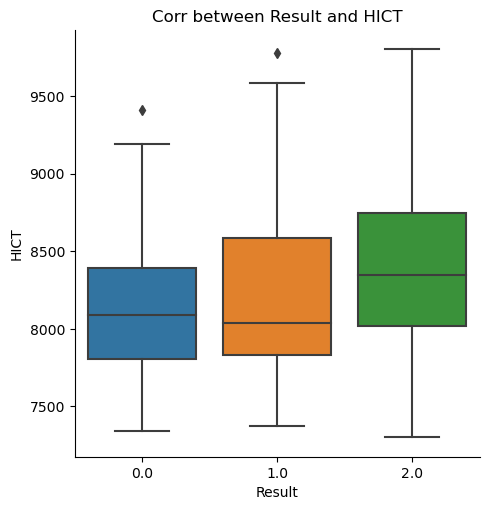

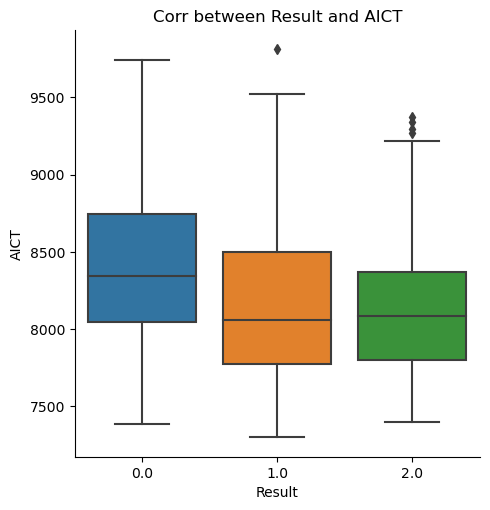

In [79]:
#box plot for result variable with DifICT, HICT, AICT
sns.catplot(data=final_dataset, x="Result", y="DifICT", kind="box")
plt.title("Corr between Result and DifICT")
plt.savefig(fname = '../figures/Corr between Result and DifICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="HICT", kind="box")
plt.title("Corr between Result and HICT")
plt.savefig(fname = '../figures/Corr between Result and HICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

sns.catplot(data=final_dataset, x="Result", y="AICT", kind="box")
plt.title("Corr between Result and AICT")
plt.savefig(fname = '../figures/Corr between Result and AICT', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

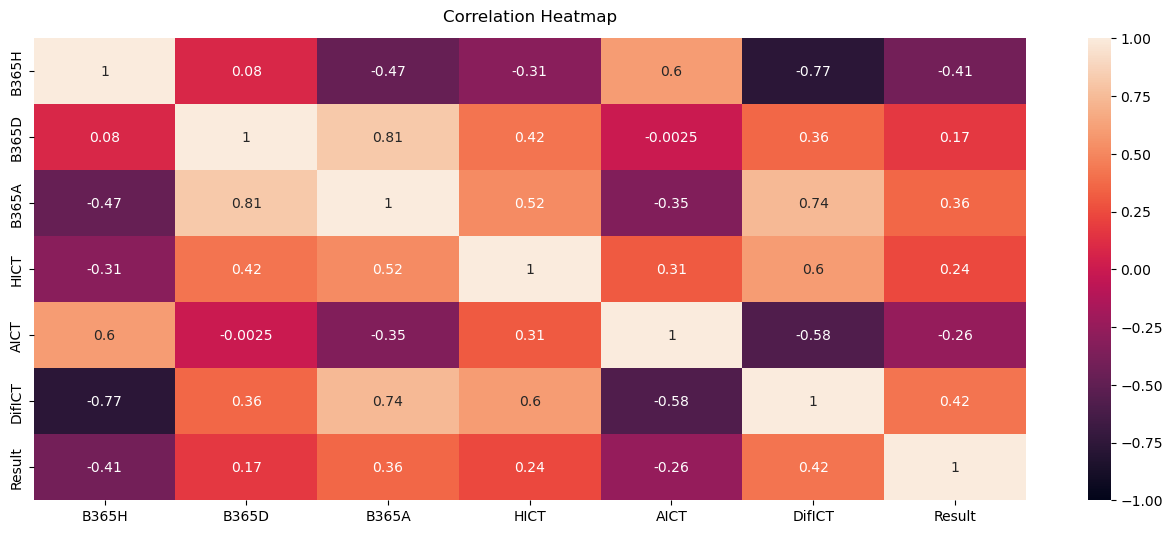

In [80]:
#Correlation Heatmap of all features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(final_dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig(fname = '../figures/Correlation Heatmap - All Features', format = 'png', dpi = 300, bbox_inches='tight')

In [81]:
#pointbiserial
from scipy.stats import pointbiserialr

copy = final_dataset
copy = copy.drop('Result', axis=1)
copy = copy.drop('Referee', axis=1)
result = final_dataset.copy()

from scipy import stats
corr_list = []
y = result['Result'].astype(float)

for column in copy:
    x=copy[column]
    corr = stats.pointbiserialr(list(x), list(y))
    corr_list.append(corr[0])
print(corr_list)

[-0.41221816029361436, 0.16942449104528334, 0.3609873022870327, 0.23713297665884991, -0.25696913103474944, 0.41921754451477955]


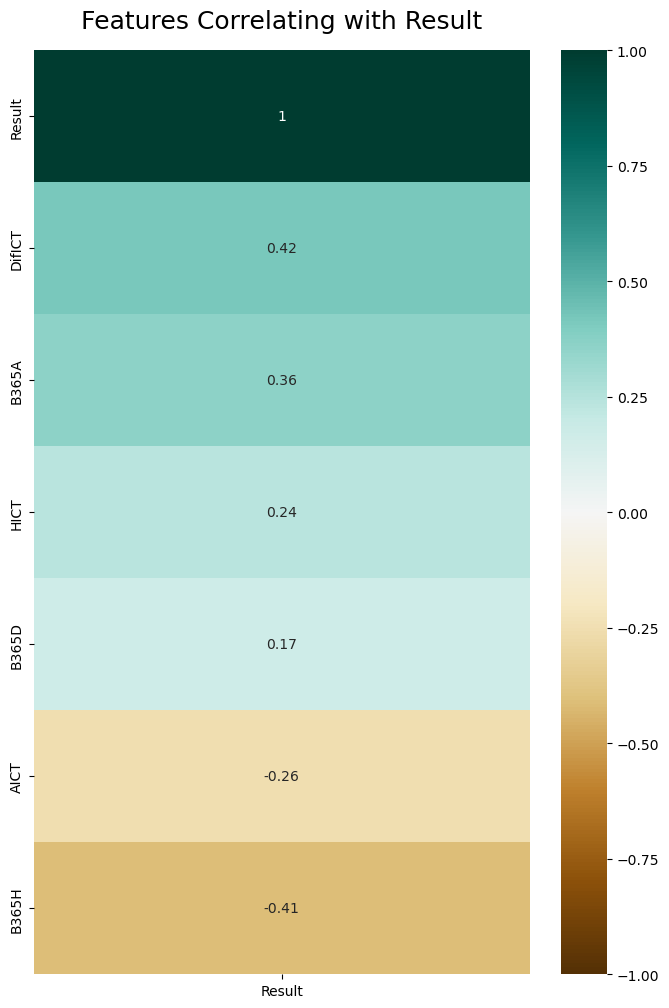

In [82]:
#Correlation Heatmap of all features with target variable
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(final_dataset.corr()[['Result']].sort_values(by='Result', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Result', fontdict={'fontsize':18}, pad=16);
plt.savefig(fname = '../figures/Features Correlating with Result', format = 'png', dpi = 300, bbox_inches='tight')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 3)'>

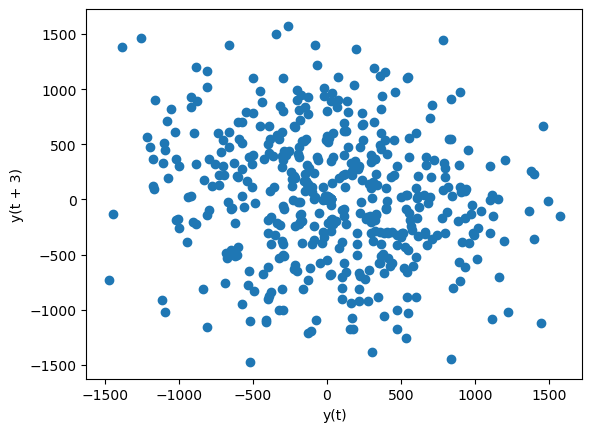

In [83]:
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
ye = final_dataset[['DifICT', 'B365A', 'B365D', 'B365H']]

pd.plotting.lag_plot(ye, lag=3)

# Lagging

In [84]:
#features to lag (lag 7)
Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y7 = final_dataset['Result']
X7 = pd.concat([Referee, Result, 
                
B365H.shift(7),B365H.shift(6),B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2), B365H.shift(1),B365H, 
                
B365D.shift(7),B365D.shift(6), B365D.shift(5),B365D.shift(4),B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, 

B365A.shift(7),B365A.shift(6), B365A.shift(5),B365A.shift(4), B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, 

HICT.shift(7),HICT.shift(6), HICT.shift(5),HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               
AICT.shift(7),AICT.shift(6), AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               
DifICT.shift(7),DifICT.shift(6), DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              
               axis=1)

X7.columns = ['Referee', 'Result',
              
              'B365H lag 7 matches','B365H lag 6 matches','B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
              'HICT lag 7 matches', 'HICT lag 6 matches', 'HICT lag 5 matches', 'HICT lag 4 matches', 
              'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
              'AICT lag 7 matches', 'AICT lag 6 matches', 'AICT lag 5 matches', 'AICT lag 4 matches', 
              'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches', 'DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X7.tail(10))
# print(y7.tail(10))

In [85]:
#lag 5
y5 = final_dataset['Result']
X5 = pd.concat([Referee, Result, B365H.shift(5),B365H.shift(4),B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(5),B365D.shift(4),B365D.shift(3),
               B365D.shift(2),B365D.shift(1),B365D, B365A.shift(5),B365A.shift(4),
               B365A.shift(3),B365A.shift(2),B365A.shift(1),B365A, HICT.shift(5),
               HICT.shift(4),HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(5),AICT.shift(4),AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, 
               DifICT.shift(5),DifICT.shift(4),DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),DifICT],
              axis=1)

X5.columns = ['Referee', 'Result',
             
             'B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
             'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
             'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
             'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
             'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
             'HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
             'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
             
             'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
             'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match',
             
             'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
             'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match'] 

# print(X5.tail(10))
# print(y5.tail(10))

In [86]:
#lag 3
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score

Referee = final_dataset['Referee']
Result = final_dataset['Result']
B365H = final_dataset['B365H']
B365D = final_dataset['B365D']
B365A = final_dataset['B365A']
HICT = final_dataset['HICT']
AICT = final_dataset['AICT']
DifICT = final_dataset['DifICT']

y3 = final_dataset['Result']
X3 = pd.concat([Referee, Result, B365H.shift(3),B365H.shift(2),
               B365H.shift(1),B365H, B365D.shift(3), B365D.shift(2),B365D.shift(1),B365D, B365A.shift(3),
               B365A.shift(2),B365A.shift(1),B365A, HICT.shift(3),HICT.shift(2),HICT.shift(1),HICT, 
               AICT.shift(3),AICT.shift(2),AICT.shift(1),AICT, DifICT.shift(3),DifICT.shift(2),DifICT.shift(1),
               DifICT],axis=1)

X3.columns = ['Referee','Result','B365H lag 3 matches', 'B365H lag 2 matches', 'B365H lag 1 match', 
             'B365H most recent match','B365D lag 3 matches','B365D lag 2 matches', 'B365D lag 1 match', 
             'B365D most recent match','B365A lag 3 matches','B365A lag 2 matches', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 3 matches','HICT lag 2 matches', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 3 matches','DifICT lag 2 matches', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X3.tail(10))
# print(y3.tail(10))

In [87]:
#lag 1
y1 = final_dataset['Result']
X1 = pd.concat([Referee, Result, B365H.shift(1),B365H, B365D.shift(1),B365D,B365A.shift(1),B365A, HICT.shift(1),
               HICT ,AICT.shift(1),AICT,DifICT.shift(1), DifICT],axis=1)

X1.columns = ['Referee', 'Result','B365H lag 1 match', 
             'B365H most recent match', 'B365D lag 1 match', 
             'B365D most recent match', 'B365A lag 1 match', 
             'B365A most recent match', 'HICT lag 1 match', 
             'HICT most recent match','AICT lag 1 match', 
             'AICT most recent match', 'DifICT lag 1 match', 
             'DifICT most recent match'] 

# print(X1.tail(10))
# print(y1.tail(10))

# Encoding

In [88]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score



# collect which encoder to use on each feature
onehot_ftrs_7 = ['Referee']
minmax_ftrs_7 = ['HICT lag 7 matches', 'HICT lag 6 matches','HICT lag 5 matches', 'HICT lag 4 matches', 
                 'HICT lag 3 matches', 'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
                 'AICT lag 7 matches', 'AICT lag 6 matches','AICT lag 5 matches', 'AICT lag 4 matches', 
                 'AICT lag 3 matches','AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_7 = ['B365H lag 7 matches', 'B365H lag 6 matches', 'B365H lag 5 matches', 'B365H lag 4 matches', 
              'B365H lag 3 matches','B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
              
              'B365D lag 7 matches', 'B365D lag 6 matches', 'B365D lag 5 matches', 'B365D lag 4 matches', 
              'B365D lag 3 matches', 'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
              
              'B365A lag 7 matches', 'B365A lag 6 matches', 'B365A lag 5 matches', 'B365A lag 4 matches', 
              'B365A lag 3 matches', 'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
              
              'DifICT lag 7 matches', 'DifICT lag 6 matches','DifICT lag 5 matches', 'DifICT lag 4 matches', 
              'DifICT lag 3 matches', 'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_7 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_7),
        ('minmax', MinMaxScaler(), minmax_ftrs_7),
        ('std', StandardScaler(), std_ftrs_7)])

#create dataframe for splitting
X7_lagged = X7.iloc[7:].reset_index(drop = True)
X7_lagged = X7_lagged.drop(['Result'], axis = 1)
y7_lagged = y7.iloc[7:].reset_index(drop = True)

In [89]:
# collect which encoder to use on each feature
onehot_ftrs_5 = ['Referee']
minmax_ftrs_5 = ['HICT lag 5 matches', 'HICT lag 4 matches', 'HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 5 matches', 'AICT lag 4 matches', 'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_5 = ['B365H lag 5 matches', 'B365H lag 4 matches', 'B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
            'B365D lag 5 matches', 'B365D lag 4 matches', 'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 5 matches', 'B365A lag 4 matches', 'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 5 matches', 'DifICT lag 4 matches', 'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_5 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_5),
        ('minmax', MinMaxScaler(), minmax_ftrs_5),
        ('std', StandardScaler(), std_ftrs_5)])

#create dataframe for splitting
X5_lagged = X5.iloc[5:].reset_index(drop = True)
X5_lagged = X5_lagged.drop(['Result'], axis = 1)

y5_lagged = y5.iloc[5:].reset_index(drop = True)

In [90]:
# collect which encoder to use on each feature
onehot_ftrs_3 = ['Referee']
minmax_ftrs_3 = ['HICT lag 3 matches', 
               'HICT lag 2 matches', 'HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 3 matches', 
               'AICT lag 2 matches', 'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_3 = ['B365H lag 3 matches', 
            'B365H lag 2 matches', 'B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 3 matches', 
            'B365D lag 2 matches', 'B365D lag 1 match', 'B365D most recent match',
             
            'B365A lag 3 matches', 
            'B365A lag 2 matches', 'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 3 matches', 
            'DifICT lag 2 matches', 'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_3),
        ('minmax', MinMaxScaler(), minmax_ftrs_3),
        ('std', StandardScaler(), std_ftrs_3)])

#create dataframe for splitting
X3_lagged = X3.iloc[3:].reset_index(drop = True)
X3_lagged = X3_lagged.drop(['Result'], axis = 1)

y3_lagged = y3.iloc[3:].reset_index(drop = True)

In [91]:
# collect which encoder to use on each feature
onehot_ftrs_1 = ['Referee']
minmax_ftrs_1 = ['HICT lag 1 match', 'HICT most recent match',       
            
               'AICT lag 1 match', 'AICT most recent match']
               
std_ftrs_1 = ['B365H lag 1 match', 'B365H most recent match',
             
           'B365D lag 1 match', 'B365D most recent match',
             
             'B365A lag 1 match', 'B365A most recent match',       
             
            'DifICT lag 1 match', 'DifICT most recent match']
    
# collect all the encoders
preprocessor_1 = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs_1),
        ('minmax', MinMaxScaler(), minmax_ftrs_1),
        ('std', StandardScaler(), std_ftrs_1)])

#create dataframe for splitting
X1_lagged = X1.iloc[1:].reset_index(drop = True)
X1_lagged = X1_lagged.drop(['Result'], axis = 1)

y1_lagged = y1.iloc[1:].reset_index(drop = True)

# Models

In [152]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import statistics as stat
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
import lightgbm as LGB

RF score: 53.0%, std: 3.0%
L1_saga score: 51.0%, std: 2.0%
L2 score: 52.0%, std: 1.0%
EN score: 53.0%, std: 2.0%
SVC score: 47.5%, std: 2.5%
CATBOOST score: 53.0%, std: 3.0%
Lightgbm score: 51.0%, std: 4.0%


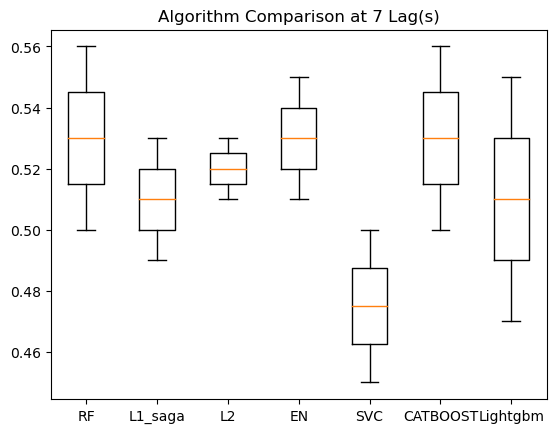

RF score: 52.5%, std: 2.5%
L1_saga score: 53.5%, std: 6.5%
L2 score: 47.5%, std: 1.5%
EN score: 53.0%, std: 3.0%
SVC score: 41.5%, std: 0.5%
CATBOOST score: 48.0%, std: 8.0%
Lightgbm score: 45.5%, std: 7.5%


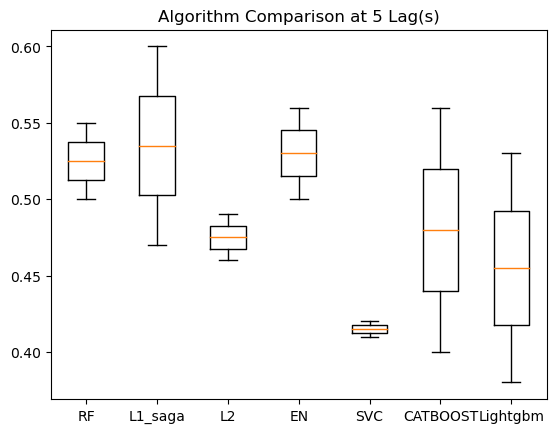

RF score: 50.0%, std: 5.4%
L1_saga score: 52.5%, std: 5.9%
L2 score: 48.5%, std: 0.0%
EN score: 51.5%, std: 3.0%
SVC score: 43.6%, std: 3.0%
CATBOOST score: 44.6%, std: 8.9%
Lightgbm score: 51.5%, std: 4.0%


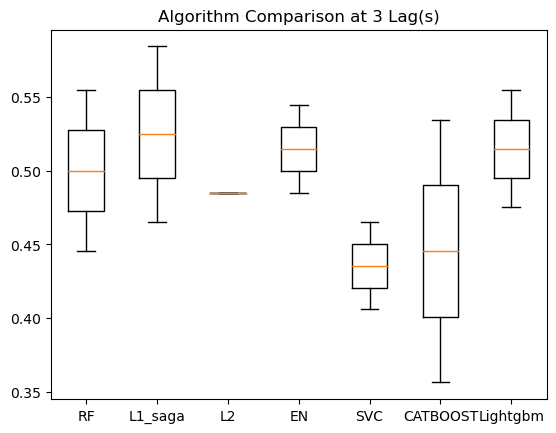

RF score: 55.4%, std: 1.0%
L1_saga score: 54.5%, std: 2.0%
L2 score: 54.5%, std: 1.0%
EN score: 54.0%, std: 1.5%
SVC score: 51.5%, std: 2.0%
CATBOOST score: 50.5%, std: 6.9%
Lightgbm score: 50.5%, std: 5.9%


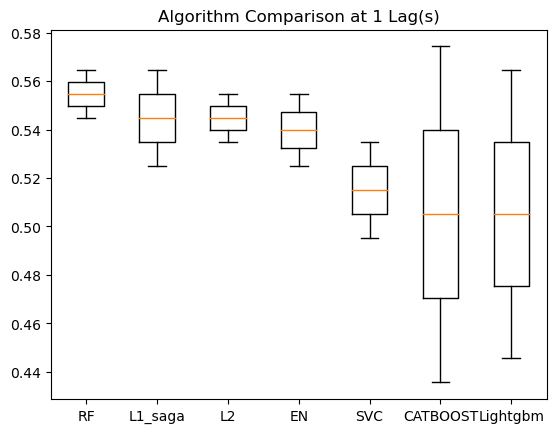

In [157]:
def Modelcomparison(X, y, preprocessor, lags): 
    '''  '''
    models = []
    models.append(('RF', RandomForestClassifier()))
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))
    models.append(('SVC', SVC()))
    models.append(('CATBOOST', CatBoostClassifier(logging_level = 'Silent')))
    models.append(('Lightgbm', LGB.LGBMClassifier()))




    # Evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        #print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.savefig(fname = '../figures/Algorith Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    
Modelcomparison(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison(X1_lagged, y1_lagged, preprocessor_1, 1)

L1_liblinear score: 53.0%, std: 5.0%
L1_saga score: 51.0%, std: 2.0%
L2 score: 52.0%, std: 1.0%
EN score: 53.0%, std: 2.0%


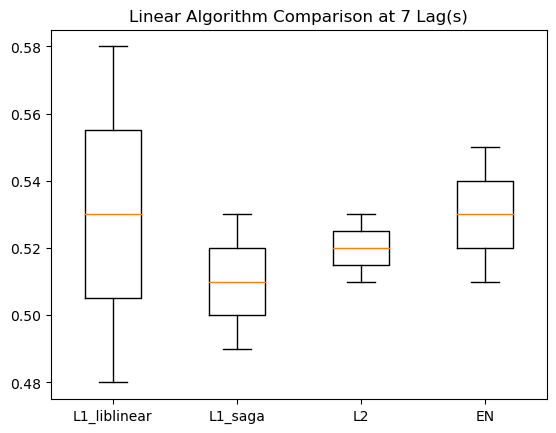

L1_liblinear score: 54.5%, std: 3.5%
L1_saga score: 53.5%, std: 6.5%
L2 score: 47.5%, std: 1.5%
EN score: 53.0%, std: 3.0%


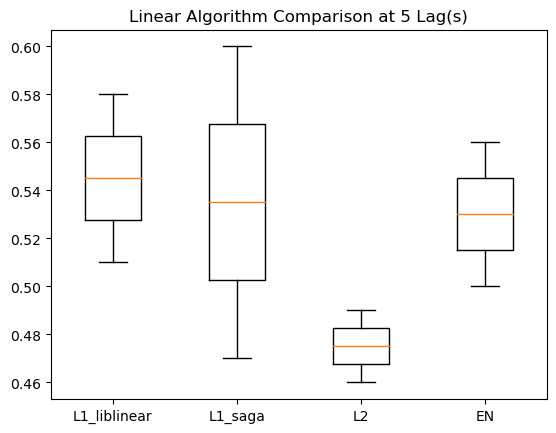

L1_liblinear score: 52.5%, std: 4.0%
L1_saga score: 52.5%, std: 5.9%
L2 score: 48.5%, std: 0.0%
EN score: 51.5%, std: 3.0%


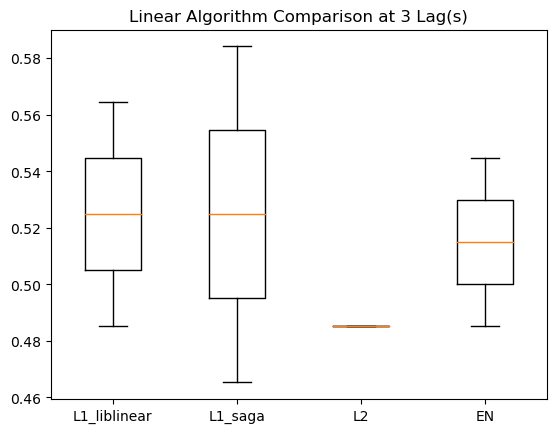

L1_liblinear score: 55.4%, std: 0.0%
L1_saga score: 54.5%, std: 2.0%
L2 score: 54.5%, std: 1.0%
EN score: 54.0%, std: 1.5%


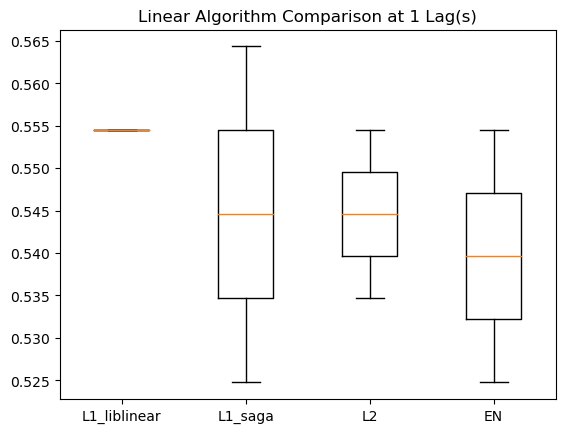

In [94]:
def Modelcomparison_log(X, y, preprocessor, lags): 
    '''  '''
    models = []
    models.append(('L1_liblinear', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'liblinear')))
    models.append(('L1_saga', LogisticRegression(max_iter= 100000,
                                                 penalty = 'l1', 
                                                 solver = 'saga')))
    models.append(('L2', LogisticRegression(penalty = 'l2')))
    models.append(('EN', LogisticRegression(max_iter= 100000, 
                                                 penalty = 'elasticnet', 
                                                 solver = 'saga', 
                                                 l1_ratio = 0.5)))

    # Evaluate each model in turn
    results = []
    names = []

    for name, model in models:
        # TimeSeries Cross validation
        tscv = TimeSeriesSplit(2)
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        prep = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_prep = prep.fit_transform(X_train)
        feature_names = prep.get_feature_names_out()
        df_train = pd.DataFrame(data=X_train_prep, columns=feature_names)
        cv_results = cross_val_score(model, df_train, y_train, cv=tscv, scoring='f1_micro')
        results.append(cv_results)
        names.append(name)
        mean = cv_results.mean() * 100
        std = cv_results.std() * 100
        
        print(f'{name} ' f'score: {mean:.1f}%,', f'std: {std:.1f}%')

    # Compare Algorithms
    plt.boxplot(results, labels=names)
    plt.title('Linear Algorithm Comparison at {} Lag(s)'.format(lags))
    plt.savefig(fname = '../figures/Linear Alg Comparison at {} Lag(s)'.format(lags), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    
Modelcomparison_log(X7_lagged, y7_lagged, preprocessor_7, 7)
Modelcomparison_log(X5_lagged, y5_lagged, preprocessor_5, 5)
Modelcomparison_log(X3_lagged, y3_lagged, preprocessor_3, 3)
Modelcomparison_log(X1_lagged, y1_lagged, preprocessor_1, 1)

In [95]:
def MLpipe_RS_LR_Lasso(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    for i in random_states:
        
        param_grid = {'ml__penalty': ['l1'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i],
                     }
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [96]:
def MLpipe_RS_LR_Ridge(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    for i in random_states:
        
        param_grid = {'ml__penalty': ['l2'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['liblinear', 'saga'],
              'ml__random_state': [i]
             }
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [97]:
def MLpipe_RS_LR_EN(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    for i in random_states:
        param_grid = {'ml__penalty': ['elasticnet'], 
              'ml__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'ml__solver': ['saga'],
              'ml__random_state': [i],
              'ml__l1_ratio': [0.01, 0.99, 15]}
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)
                
            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
           
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [98]:
def MLpipe_RS_SVC(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    
    for i in random_states:
        param_grid = {'ml__C': [1, 3, 10, 30, 100],
              'ml__kernel': ['linear'],
              'ml__gamma': ['auto', 'scale'],
              'ml__degree': range(1, 6, 1),
              'ml__probability': [True],
              'ml__random_state': [i]}
        
        split_scores = []
        
        tscv = TimeSeriesSplit(n_splits)  
        
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)

            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [164]:
def MLpipe_RS_RF(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_states = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    for i in random_states:
        
        param_grid = {'ml__max_depth': [10],
                      'ml__min_samples_leaf': [1, 3,5],
                      'ml__n_estimators': [50,100,200,500],
                      'ml__max_features': ['auto', 'sqrt', 'log2'],
                      'ml__random_state': [i]
             }
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
            
            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [99]:
def MLpipe_RS_CAT(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_seed = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    for i in random_seed:
        
        param_grid = {'ml__depth':[3, 1, 10],
              'ml__random_seed': [i],
              'ml__iterations':[1, 10, 25],
              'ml__learning_rate':[.01, 0.03], 
              'ml__l2_leaf_reg':[5, 10, 100],
              'ml__border_count':[32, 5],
              'ml__thread_count':[4]}
        
        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
            
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
           
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [100]:
def MLpipe_RS_lgb(X, y, model, n_splits, preprocessor, scoring, refit, lags):
    ''''''
    tscv = TimeSeriesSplit(n_splits)

    best_models = []
    best_scores = []
    cm = []
    random_state = [1, 10, 42, 60, 90]
    baseline_scores = []
    
    for i in random_state:
    
        
        param_grid ={
            'ml__n_estimators': [5],
            'ml__num_leaves': [3,6,8,31], 
            'ml__max_depth': [40],
            'ml__colsample_bytree': [0.99],
            'ml__min_child_samples': [5,20,25,50], 
            'ml__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
            'ml__random_state': [i]}
    

        split_scores = []
            
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipe = Pipeline(steps=[('preprocessor', preprocessor), ('ml', model)])
            gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = scoring, refit = refit)
            gsearch.fit(X_train, y_train) 

            best_model = gsearch.best_estimator_
            best_score = gsearch.best_score_
            best_param = gsearch.best_params_
            feature_names = best_model[:-1].get_feature_names_out()

            y_pred = best_model.predict(X_test)
            test_score = accuracy_score(y_test,y_pred)
            best_scores.append(test_score)
            split_scores.append(test_score)
            cm.append(confusion_matrix(y_test,y_pred))
            best_models.append(best_model)
            
            wins = len(y_test.loc[y_test == 2.0])
            draws = len(y_test.loc[y_test == 0.0])
            loses = len(y_test.loc[y_test == 1.0])
            total_length = len(y_test)

            if wins > draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins > loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins >= draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length
                
            elif wins > draws and wins >= loses:
                chosen = wins
                baseline = chosen/total_length  
                
            elif loses > draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif loses >= draws and loses > wins:
                chosen = loses
                baseline = chosen/total_length
                
            elif draws > wins and draws > loses:
                chosen = draws
                baseline = chosen/total_length

            baseline_scores.append(baseline)
            print('---------------------------------------------------------------------------------------------------')
           
            print('\nBest Parameters\n')
            print(best_param)
            
            print('\nConfusion Matrix\n')
            print(confusion_matrix(y_test,y_pred))
            
            print('\nResult Distribution\n')
            print(y_test.value_counts())
            
            print('\nBaseline Score: {:.2f}'.format(baseline))
            
            print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

            print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
            print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
            print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

            print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
            print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
            print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

            print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
            print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
            print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

            print('\nClassification Report\n')
            print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
       
        score_split = stat.mean(split_scores) * 100
        score_split = score_split.round(3)
        std_split = stat.stdev(best_scores) * 100
        std_split = round(std_split,3)
        print('---------------------------------------------------------------------------------------------------')
        print('---------------------------------------------------------------------------------------------------')
        print(f'model: {model}, ' f'Averaged Split Accuracy score: {score_split:.2f}%, ' f'std: {std_split:.2f}%, ' f'# of Lags: {lags:.0f}')
        print('---------------------------------------------------------------------------------------------------')
    
    score = stat.mean(best_scores) * 100
    score = score.round(3)
    std = stat.stdev(best_scores) * 100
    std = round(std,3)
    
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    print(f'model: {model}, ' f'Averaged Accuracy score: {score:.2f}%, ' f'std: {std:.2f}%, ' f'# of Lags: {lags:.0f}')
    print('---------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------')
    
    return best_models, best_scores, cm, lags, baseline_scores


In [101]:
lasso = LogisticRegression(max_iter=1)

lasso7, score_lasso7, cm_lasso7, lags_lasso7, baselinelasso7 = MLpipe_RS_LR_Lasso(X7_lagged, y7_lagged, lasso, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lasso5, score_lasso5, cm_lasso5, lags_lasso5, baselinelasso5= MLpipe_RS_LR_Lasso(X5_lagged, y5_lagged, lasso, 2, preprocessor_5,'f1_micro','f1_micro',5)
lasso3, score_lasso3, cm_lasso3, lags_lasso3, baselinelasso3= MLpipe_RS_LR_Lasso(X3_lagged, y3_lagged, lasso, 2, preprocessor_3,'f1_macro','f1_micro',3)
lasso1, score_lasso1, cm_lasso1, lags_lasso1, baselinelasso1= MLpipe_RS_LR_Lasso(X1_lagged, y1_lagged, lasso, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l1', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[28  9 22]
 [ 8 10 12]
 [ 9 10 42]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.54
Weighted Recall: 0.53
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.47      0.54        59
     Class 2       0.34      0.33      0.34        30
     Class 3       0.55      0.69      0.61        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.50       150
weighted avg       0.54      0.53      0.53       150

--------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l1', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[32  0 27]
 [12  0 18]
 [ 8  1 52]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.56

Micro Precision: 0.56
Micro Recall: 0.56
Micro F1-score: 0.56

Macro Precision: 0.38
Macro Recall: 0.46
Macro F1-score: 0.41

Weighted Precision: 0.46
Weighted Recall: 0.56
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.54      0.58        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.54      0.85      0.66        61

    accuracy                           0.56       150
   macro avg       0.38      0.46      0.41       150
weighted avg       0.46      0.56      0.49       150

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l1', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[18  6 15]
 [12  7 21]
 [11  9 51]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.45
Macro Recall: 0.45
Macro F1-score: 0.44

Weighted Precision: 0.48
Weighted Recall: 0.51
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.44      0.46      0.45        39
     Class 2       0.32      0.17      0.23        40
     Class 3       0.59      0.72      0.65        71

    accuracy                           0.51       150
   macro avg       0.45      0.45      0.44       150
weighted avg       0.48      0.51      0.48       150

---------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__penalty': 'l1', 'ml__random_state': 10, 'ml__solver': 'liblinear'}

Confusion Matrix

[[24 11 24]
 [11  6 13]
 [ 8  9 45]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.45
Macro Recall: 0.44
Macro F1-score: 0.44

Weighted Precision: 0.49
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.56      0.41      0.47        59
     Class 2       0.23      0.20      0.21        30
     Class 3       0.55      0.73      0.63        62

    accuracy                           0.50       151
   macro avg       0.45      0.44      0.44       151
weighted avg       0.49      0.50      0.48       151

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__penalty': 'l1', 'ml__random_state': 1, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  9 24]
 [11  4 15]
 [ 8  7 48]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.44
Macro Recall: 0.45
Macro F1-score: 0.43

Weighted Precision: 0.49
Weighted Recall: 0.51
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.58      0.44      0.50        59
     Class 2       0.20      0.13      0.16        30
     Class 3       0.55      0.76      0.64        63

    accuracy                           0.51       152
   macro avg       0.44      0.45      0.43       152
weighted avg       0.49      0.51      0.49       152

---------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 10, 'ml__penalty': 'l1', 'ml__random_state': 90, 'ml__solver': 'saga'}

Confusion Matrix

[[26  9 24]
 [ 9  4 17]
 [ 3  6 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.49
Macro Recall: 0.48
Macro F1-score: 0.46

Weighted Precision: 0.54
Weighted Recall: 0.55
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.44      0.54        59
     Class 2       0.21      0.13      0.16        30
     Class 3       0.57      0.86      0.68        63

    accuracy                           0.55       152
   macro avg       0.49      0.48      0.46       152
weighted avg       0.54      0.55      0.52       152

--------------------------

In [102]:
ridge = LogisticRegression(max_iter=1)

ridge7, score_ridge7, cm_ridge7, lags_ridge7, baselineridge7 = MLpipe_RS_LR_Ridge(X7_lagged, y7_lagged, ridge, 2,  preprocessor_7,'f1_micro','f1_micro',7)
ridge5, score_ridge5, cm_ridge5, lags_ridge5, baselineridge5 = MLpipe_RS_LR_Ridge(X5_lagged, y5_lagged, ridge, 2, preprocessor_5,'f1_micro','f1_micro',5)
ridge3, score_ridge3, cm_ridge3, lags_ridge3, baselineridge3 = MLpipe_RS_LR_Ridge(X3_lagged, y3_lagged, ridge, 2, preprocessor_3,'f1_macro','f1_micro',3)
ridge1, score_ridge1, cm_ridge1, lags_rigde1, baselineridge1 = MLpipe_RS_LR_Ridge(X1_lagged, y1_lagged, ridge, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.01, 'ml__penalty': 'l2', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[22 11 26]
 [ 7 11 12]
 [ 5 10 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.49

Weighted Precision: 0.55
Weighted Recall: 0.53
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.65      0.37      0.47        59
     Class 2       0.34      0.37      0.35        30
     Class 3       0.55      0.75      0.63        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.49       150
weighted avg       0.55      0.53      0.52       150

-------------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__penalty': 'l2', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[25  9 25]
 [11  4 15]
 [ 5 10 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.44
Macro Recall: 0.44
Macro F1-score: 0.43

Weighted Precision: 0.49
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.61      0.42      0.50        59
     Class 2       0.17      0.13      0.15        30
     Class 3       0.53      0.75      0.63        61

    accuracy                           0.50       150
   macro avg       0.44      0.44      0.43       150
weighted avg       0.49      0.50      0.48       150

--------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.001, 'ml__penalty': 'l2', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[16  0 23]
 [10  0 30]
 [ 9  0 62]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.33
Macro Recall: 0.43
Macro F1-score: 0.37

Weighted Precision: 0.37
Weighted Recall: 0.52
Weighted F1-score: 0.43

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.41      0.43        39
     Class 2       0.00      0.00      0.00        40
     Class 3       0.54      0.87      0.67        71

    accuracy                           0.52       150
   macro avg       0.33      0.43      0.37       150
weighted avg       0.37      0.52      0.43       150

-----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 10, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26 11 22]
 [ 8  4 18]
 [ 4  5 53]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.48
Macro F1-score: 0.46

Weighted Precision: 0.54
Weighted Recall: 0.55
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.44      0.54        59
     Class 2       0.20      0.13      0.16        30
     Class 3       0.57      0.85      0.68        62

    accuracy                           0.55       151
   macro avg       0.48      0.48      0.46       151
weighted avg       0.54      0.55      0.52       151

----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 1, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  6 27]
 [ 9  3 18]
 [ 6  3 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.44

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.44      0.52        59
     Class 2       0.25      0.10      0.14        30
     Class 3       0.55      0.86      0.67        63

    accuracy                           0.55       152
   macro avg       0.48      0.47      0.44       152
weighted avg       0.52      0.55      0.51       152

-----------------------

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__penalty': 'l2', 'ml__random_state': 90, 'ml__solver': 'liblinear'}

Confusion Matrix

[[26  6 27]
 [ 9  3 18]
 [ 6  3 54]]

Result Distribution

2.0    63
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.44

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.44      0.52        59
     Class 2       0.25      0.10      0.14        30
     Class 3       0.55      0.86      0.67        63

    accuracy                           0.55       152
   macro avg       0.48      0.47      0.44       152
weighted avg       0.52      0.55      0.51       152

----------------------

In [103]:
en = LogisticRegression(max_iter=1)

EN7_LR, score_en7, cm_en7, lags_en7, baselineen7 = MLpipe_RS_LR_EN(X7_lagged, y7_lagged, en, 2,  preprocessor_7,'f1_micro','f1_micro',7)
EN5_LR, score_en5, cm_en5, lags_en5, baselineen5 = MLpipe_RS_LR_EN(X5_lagged, y5_lagged, en, 2, preprocessor_5,'f1_micro','f1_micro',5)
EN3_LR, score_en3, cm_en3, lags_en3,baselineen3 = MLpipe_RS_LR_EN(X3_lagged, y3_lagged, en, 2, preprocessor_3,'f1_macro','f1_micro',3)
EN1_LR, score_en1, cm_en1, lags_en1,baselineen1 = MLpipe_RS_LR_EN(X1_lagged, y1_lagged, en, 2, preprocessor_1,'f1_macro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 0.1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[28  9 22]
 [ 8 10 12]
 [ 9 10 42]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.51
Macro Recall: 0.50
Macro F1-score: 0.50

Weighted Precision: 0.54
Weighted Recall: 0.53
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.62      0.47      0.54        59
     Class 2       0.34      0.33      0.34        30
     Class 3       0.55      0.69      0.61        61

    accuracy                           0.53       150
   macro avg       0.51      0.50      0.50       150
weighted avg       0.54      0.53      0.53       1

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 60, 'ml__solver': 'saga'}

Confusion Matrix

[[21  7 11]
 [18  7 15]
 [18 13 40]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.45

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.41
Macro Recall: 0.43
Macro F1-score: 0.41

Weighted Precision: 0.45
Weighted Recall: 0.45
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.37      0.54      0.44        39
     Class 2       0.26      0.17      0.21        40
     Class 3       0.61      0.56      0.58        71

    accuracy                           0.45       150
   macro avg       0.41      0.43      0.41       150
weighted avg       0.45      0.45      0.45       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[27 10 22]
 [ 8  6 16]
 [ 6 10 45]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.48
Macro Recall: 0.47
Macro F1-score: 0.46

Weighted Precision: 0.53
Weighted Recall: 0.52
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.66      0.46      0.54        59
     Class 2       0.23      0.20      0.21        30
     Class 3       0.54      0.74      0.62        61

    accuracy                           0.52       150
   macro avg       0.48      0.47      0.46       150
weighted avg       0.53      0.52      0.51       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 100, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 1, 'ml__solver': 'saga'}

Confusion Matrix

[[19  9 11]
 [13  6 21]
 [12 17 43]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.45

Micro Precision: 0.45
Micro Recall: 0.45
Micro F1-score: 0.45

Macro Precision: 0.40
Macro Recall: 0.41
Macro F1-score: 0.40

Weighted Precision: 0.43
Weighted Recall: 0.45
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.43      0.49      0.46        39
     Class 2       0.19      0.15      0.17        40
     Class 3       0.57      0.60      0.59        72

    accuracy                           0.45       151
   macro avg       0.40      0.41      0.40       151
weighted avg       0.43      0.45      0.44       1

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.01, 'ml__penalty': 'elasticnet', 'ml__random_state': 90, 'ml__solver': 'saga'}

Confusion Matrix

[[23  3 33]
 [ 7  4 19]
 [ 5  5 52]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.50
Macro Recall: 0.45
Macro F1-score: 0.44

Weighted Precision: 0.53
Weighted Recall: 0.52
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.66      0.39      0.49        59
     Class 2       0.33      0.13      0.19        30
     Class 3       0.50      0.84      0.63        62

    accuracy                           0.52       151
   macro avg       0.50      0.45      0.44       151
weighted avg       0.53      0.52      0.49       15

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__l1_ratio': 0.99, 'ml__penalty': 'elasticnet', 'ml__random_state': 42, 'ml__solver': 'saga'}

Confusion Matrix

[[25  1 13]
 [13  1 26]
 [20  1 52]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.51

Micro Precision: 0.51
Micro Recall: 0.51
Micro F1-score: 0.51

Macro Precision: 0.45
Macro Recall: 0.46
Macro F1-score: 0.40

Weighted Precision: 0.47
Weighted Recall: 0.51
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.43      0.64      0.52        39
     Class 2       0.33      0.03      0.05        40
     Class 3       0.57      0.71      0.63        73

    accuracy                           0.51       152
   macro avg       0.45      0.46      0.40       152
weighted avg       0.47      0.51      0.45       15

In [104]:
svc = SVC()

svc7, score_svc7, cm_svc5, lags_svc7, baselinesvc7 = MLpipe_RS_SVC(X7_lagged, y7_lagged, svc, 2, preprocessor_7, 'accuracy', 'f1_micro',7)
svc5, score_svc5, cm_svc5, lags_svc5,baselinesvc5 = MLpipe_RS_SVC(X5_lagged, y5_lagged, svc, 2, preprocessor_5, 'accuracy', 'f1_micro',5)
svc3, score_svc3, cm_svc3, lags_svc3 ,baselinesvc3= MLpipe_RS_SVC(X3_lagged, y3_lagged, svc, 2, preprocessor_3, 'accuracy', 'f1_micro',3)
svc1, score_svc1, cm_svc1, lags_svc1 ,baselinesvc1= MLpipe_RS_SVC(X1_lagged, y1_lagged, svc, 2, preprocessor_1, 'accuracy', 'f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 1}

Confusion Matrix

[[17  7 35]
 [ 5  5 20]
 [ 4  7 50]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.48

Micro Precision: 0.48
Micro Recall: 0.48
Micro F1-score: 0.48

Macro Precision: 0.46
Macro Recall: 0.42
Macro F1-score: 0.40

Weighted Precision: 0.50
Weighted Recall: 0.48
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.65      0.29      0.40        59
     Class 2       0.26      0.17      0.20        30
     Class 3       0.48      0.82      0.60        61

    accuracy                           0.48       150
   macro avg       0.46      0.42      0.40       150
weighted avg       0.50      0.48      

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 60}

Confusion Matrix

[[22  8  9]
 [14 10 16]
 [16  9 46]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.52

Micro Precision: 0.52
Micro Recall: 0.52
Micro F1-score: 0.52

Macro Precision: 0.48
Macro Recall: 0.49
Macro F1-score: 0.48

Weighted Precision: 0.52
Weighted Recall: 0.52
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.42      0.56      0.48        39
     Class 2       0.37      0.25      0.30        40
     Class 3       0.65      0.65      0.65        71

    accuracy                           0.52       150
   macro avg       0.48      0.49      0.48       150
weighted avg       0.52      0.52     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 10, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 42}

Confusion Matrix

[[18  6 35]
 [ 8  1 21]
 [ 9  6 46]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.35
Macro Recall: 0.36
Macro F1-score: 0.33

Weighted Precision: 0.40
Weighted Recall: 0.43
Weighted F1-score: 0.39

Classification Report

              precision    recall  f1-score   support

     Class 1       0.51      0.31      0.38        59
     Class 2       0.08      0.03      0.05        30
     Class 3       0.45      0.75      0.56        61

    accuracy                           0.43       150
   macro avg       0.35      0.36      0.33       150
weighted avg       0.40      0.43    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 3, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 1}

Confusion Matrix

[[23  7  9]
 [15  5 20]
 [19 12 41]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.46

Micro Precision: 0.46
Micro Recall: 0.46
Micro F1-score: 0.46

Macro Precision: 0.40
Macro Recall: 0.43
Macro F1-score: 0.40

Weighted Precision: 0.44
Weighted Recall: 0.46
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 1       0.40      0.59      0.48        39
     Class 2       0.21      0.12      0.16        40
     Class 3       0.59      0.57      0.58        72

    accuracy                           0.46       151
   macro avg       0.40      0.43      0.40       151
weighted avg       0.44      0.46      

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 3, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 90}

Confusion Matrix

[[23  7 29]
 [ 6  7 17]
 [12  4 46]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.48
Macro Recall: 0.46
Macro F1-score: 0.45

Weighted Precision: 0.50
Weighted Recall: 0.50
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.56      0.39      0.46        59
     Class 2       0.39      0.23      0.29        30
     Class 3       0.50      0.74      0.60        62

    accuracy                           0.50       151
   macro avg       0.48      0.46      0.45       151
weighted avg       0.50      0.50     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__C': 1, 'ml__degree': 1, 'ml__gamma': 'auto', 'ml__kernel': 'linear', 'ml__probability': True, 'ml__random_state': 42}

Confusion Matrix

[[23  6 10]
 [20  4 16]
 [26  9 38]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.43

Micro Precision: 0.43
Micro Recall: 0.43
Micro F1-score: 0.43

Macro Precision: 0.38
Macro Recall: 0.40
Macro F1-score: 0.37

Weighted Precision: 0.43
Weighted Recall: 0.43
Weighted F1-score: 0.41

Classification Report

              precision    recall  f1-score   support

     Class 1       0.33      0.59      0.43        39
     Class 2       0.21      0.10      0.14        40
     Class 3       0.59      0.52      0.55        73

    accuracy                           0.43       152
   macro avg       0.38      0.40      0.37       152
weighted avg       0.43      0.43     

In [165]:
RF = RandomForestClassifier()

rf7, score_rf7, cm_rf5, lags_rf7, baselinerf7 = MLpipe_RS_RF(X7_lagged, y7_lagged, RF, 2, preprocessor_7, 'accuracy', 'f1_micro',7)
rf5, score_rf5, cm_rf5, lags_rf5,baselinerf5 = MLpipe_RS_RF(X5_lagged, y5_lagged, RF, 2, preprocessor_5, 'accuracy', 'f1_micro',5)
rf3, score_rf3, cm_rf3, lags_rf3 ,baselinerf3= MLpipe_RS_RF(X3_lagged, y3_lagged, RF, 2, preprocessor_3, 'accuracy', 'f1_micro',3)
rf1, score_rf1, cm_rf1, lags_rf1 ,baselinerf1= MLpipe_RS_RF(X1_lagged, y1_lagged, RF, 2, preprocessor_1, 'accuracy', 'f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 200, 'ml__random_state': 1}

Confusion Matrix

[[32  3 24]
 [11  1 18]
 [ 7  0 54]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.48
Macro Recall: 0.49
Macro F1-score: 0.44

Weighted Precision: 0.53
Weighted Recall: 0.58
Weighted F1-score: 0.52

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.54      0.59        59
     Class 2       0.25      0.03      0.06        30
     Class 3       0.56      0.89      0.69        61

    accuracy                           0.58       150
   macro avg       0.48      0.49      0.44       150
weighted avg       0.53      0.58    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 200, 'ml__random_state': 60}

Confusion Matrix

[[26  3 10]
 [13  4 23]
 [14  6 51]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.47
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.50
Weighted Recall: 0.54
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.49      0.67      0.57        39
     Class 2       0.31      0.10      0.15        40
     Class 3       0.61      0.72      0.66        71

    accuracy                           0.54       150
   macro avg       0.47      0.49      0.46       150
weighted avg       0.50      0.54   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 3, 'ml__n_estimators': 50, 'ml__random_state': 42}

Confusion Matrix

[[27  7 25]
 [11  3 16]
 [ 5  3 53]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.47
Macro Recall: 0.48
Macro F1-score: 0.45

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.46      0.53        59
     Class 2       0.23      0.10      0.14        30
     Class 3       0.56      0.87      0.68        61

    accuracy                           0.55       150
   macro avg       0.47      0.48      0.45       150
weighted avg       0.52      0.55    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'log2', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 100, 'ml__random_state': 1}

Confusion Matrix

[[25  2 12]
 [14  5 21]
 [13  6 53]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.49
Macro Recall: 0.50
Macro F1-score: 0.47

Weighted Precision: 0.52
Weighted Recall: 0.55
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.64      0.55        39
     Class 2       0.38      0.12      0.19        40
     Class 3       0.62      0.74      0.67        72

    accuracy                           0.55       151
   macro avg       0.49      0.50      0.47       151
weighted avg       0.52      0.55    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'auto', 'ml__min_samples_leaf': 3, 'ml__n_estimators': 100, 'ml__random_state': 90}

Confusion Matrix

[[32  2 25]
 [10  3 17]
 [ 8  3 51]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.52
Macro Recall: 0.49
Macro F1-score: 0.47

Weighted Precision: 0.55
Weighted Recall: 0.57
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.54      0.59        59
     Class 2       0.38      0.10      0.16        30
     Class 3       0.55      0.82      0.66        62

    accuracy                           0.57       151
   macro avg       0.52      0.49      0.47       151
weighted avg       0.55      0.57   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__max_depth': 10, 'ml__max_features': 'log2', 'ml__min_samples_leaf': 5, 'ml__n_estimators': 500, 'ml__random_state': 42}

Confusion Matrix

[[26  3 10]
 [14  5 21]
 [15  9 49]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.46
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.49
Weighted Recall: 0.53
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.47      0.67      0.55        39
     Class 2       0.29      0.12      0.18        40
     Class 3       0.61      0.67      0.64        73

    accuracy                           0.53       152
   macro avg       0.46      0.49      0.46       152
weighted avg       0.49      0.53   

In [105]:
CATB = CatBoostClassifier(logging_level = 'Silent')

cat7, score_cat7, cm_cat7, lags_cat7,baselinecat7 = MLpipe_RS_CAT(X7_lagged, y7_lagged, CATB, 2,  preprocessor_7,'f1_micro','f1_micro',7)
cat5, score_cat5, cm_cat5, lags_cat5,baselinecat5 = MLpipe_RS_CAT(X5_lagged, y5_lagged, CATB, 2, preprocessor_5,'f1_micro','f1_micro',5)
cat3, score_cat3, cm_cat3, lags_cat3,baselinecat3 = MLpipe_RS_CAT(X3_lagged, y3_lagged, CATB, 2, preprocessor_3,'f1_micro','f1_micro',3)
cat, score_cat, cm_cat, lags_cat ,baselinecat1= MLpipe_RS_CAT(X1_lagged, y1_lagged, CATB, 2, preprocessor_1,'f1_micro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.01, 'ml__random_seed': 1, 'ml__thread_count': 4}

Confusion Matrix

[[30  0 29]
 [11  1 18]
 [ 6  0 55]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.73
Macro Recall: 0.48
Macro F1-score: 0.44

Weighted Precision: 0.67
Weighted Recall: 0.57
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.64      0.51      0.57        59
     Class 2       1.00      0.03      0.06        30
     Class 3       0.54      0.90      0.67        61

    accuracy                           0.57       150
   macro avg       0.73      0.48      0.44       150
weigh

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.03, 'ml__random_seed': 60, 'ml__thread_count': 4}

Confusion Matrix

[[28  0 11]
 [14  0 26]
 [19  0 52]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.35
Macro Recall: 0.48
Macro F1-score: 0.40

Weighted Precision: 0.40
Weighted Recall: 0.53
Weighted F1-score: 0.45

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.72      0.56        39
     Class 2       0.00      0.00      0.00        40
     Class 3       0.58      0.73      0.65        71

    accuracy                           0.53       150
   macro avg       0.35      0.48      0.40       150
weig

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 1, 'ml__iterations': 25, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.01, 'ml__random_seed': 42, 'ml__thread_count': 4}

Confusion Matrix

[[36  0 23]
 [12  0 18]
 [12  0 49]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.57

Micro Precision: 0.57
Micro Recall: 0.57
Micro F1-score: 0.57

Macro Precision: 0.38
Macro Recall: 0.47
Macro F1-score: 0.42

Weighted Precision: 0.46
Weighted Recall: 0.57
Weighted F1-score: 0.50

Classification Report

              precision    recall  f1-score   support

     Class 1       0.60      0.61      0.61        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.54      0.80      0.65        61

    accuracy                           0.57       150
   macro avg       0.38      0.47      0.42       150
we

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 5, 'ml__learning_rate': 0.01, 'ml__random_seed': 1, 'ml__thread_count': 4}

Confusion Matrix

[[26  0 13]
 [13  1 26]
 [15  0 57]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.56

Micro Precision: 0.56
Micro Recall: 0.56
Micro F1-score: 0.56

Macro Precision: 0.69
Macro Recall: 0.49
Macro F1-score: 0.43

Weighted Precision: 0.67
Weighted Recall: 0.56
Weighted F1-score: 0.48

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.67      0.56        39
     Class 2       1.00      0.03      0.05        40
     Class 3       0.59      0.79      0.68        72

    accuracy                           0.56       151
   macro avg       0.69      0.49      0.43       151
weigh

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 32, 'ml__depth': 1, 'ml__iterations': 10, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.01, 'ml__random_seed': 90, 'ml__thread_count': 4}

Confusion Matrix

[[36  0 23]
 [12  0 18]
 [11  0 51]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.39
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.47
Weighted Recall: 0.58
Weighted F1-score: 0.51

Classification Report

              precision    recall  f1-score   support

     Class 1       0.61      0.61      0.61        59
     Class 2       0.00      0.00      0.00        30
     Class 3       0.55      0.82      0.66        62

    accuracy                           0.58       151
   macro avg       0.39      0.48      0.42       151
we

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__border_count': 5, 'ml__depth': 3, 'ml__iterations': 10, 'ml__l2_leaf_reg': 100, 'ml__learning_rate': 0.03, 'ml__random_seed': 42, 'ml__thread_count': 4}

Confusion Matrix

[[30  0  9]
 [16  2 22]
 [21  0 52]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.69
Macro Recall: 0.51
Macro F1-score: 0.44

Weighted Precision: 0.68
Weighted Recall: 0.55
Weighted F1-score: 0.49

Classification Report

              precision    recall  f1-score   support

     Class 1       0.45      0.77      0.57        39
     Class 2       1.00      0.05      0.10        40
     Class 3       0.63      0.71      0.67        73

    accuracy                           0.55       152
   macro avg       0.69      0.51      0.44       152
wei

In [228]:
LGGclass =  LGB.LGBMClassifier()

lgb7, score_lgb7, cm_lgb7, lags_lgb7, baselinelgb7 = MLpipe_RS_lgb(X7_lagged, y7_lagged, LGGclass, 2,  preprocessor_7,'f1_micro','f1_micro',7)
lgb5, score_lgb5, cm_lgb5, lags_lgb5, baselinelgb5 = MLpipe_RS_lgb(X5_lagged, y5_lagged, LGGclass, 2, preprocessor_5,'f1_micro','f1_micro',5)
lgb3, score_lgb3, cm_lgb3, lags_lgb3, baselinelgb3 = MLpipe_RS_lgb(X3_lagged, y3_lagged, LGGclass, 2, preprocessor_3,'f1_micro','f1_micro',3)
lgb1, score_lgb, cm_lgb, lags_lgb, baselinelgb1 = MLpipe_RS_lgb(X1_lagged, y1_lagged, LGGclass, 2, preprocessor_1,'f1_micro','f1_micro',1)


---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 1}

Confusion Matrix

[[34  0 25]
 [10  2 18]
 [ 6  0 55]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.75
Macro Recall: 0.51
Macro F1-score: 0.48

Weighted Precision: 0.70
Weighted Recall: 0.61
Weighted F1-score: 0.55

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.58      0.62        59
     Class 2       1.00      0.07      0.12        30
     Class 3       0.56      0.90      0.69        61

    accuracy                           0.61       150
   macro avg       0.75      0.51    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 60}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [17  0 54]]

Result Distribution

2.0    71
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.47
Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.69
Macro Recall: 0.49
Macro F1-score: 0.42

Weighted Precision: 0.67
Weighted Recall: 0.55
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.47      0.69      0.56        39
     Class 2       1.00      0.03      0.05        40
     Class 3       0.59      0.76      0.67        71

    accuracy                           0.55       150
   macro avg       0.69      0.49   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 5, 'ml__min_child_weight': 10.0, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 42}

Confusion Matrix

[[36  0 23]
 [10  2 18]
 [11  1 49]]

Result Distribution

2.0    61
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.61
Macro Recall: 0.49
Macro F1-score: 0.46

Weighted Precision: 0.60
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.61      0.62        59
     Class 2       0.67      0.07      0.12        30
     Class 3       0.54      0.80      0.65        61

    accuracy                           0.58       150
   macro avg       0.61      0.49     

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 20, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 1}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [15  4 53]]

Result Distribution

2.0    72
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.54

Micro Precision: 0.54
Micro Recall: 0.54
Micro F1-score: 0.54

Macro Precision: 0.42
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.46
Weighted Recall: 0.54
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.48      0.69      0.57        39
     Class 2       0.20      0.03      0.04        40
     Class 3       0.59      0.74      0.65        72

    accuracy                           0.54       151
   macro avg       0.42      0.48    

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 25, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 90}

Confusion Matrix

[[36  0 23]
 [10  2 18]
 [11  1 50]]

Result Distribution

2.0    62
0.0    59
1.0    30
Name: Result, dtype: int64

Baseline Score: 0.41
Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.62
Macro Recall: 0.49
Macro F1-score: 0.47

Weighted Precision: 0.60
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 1       0.63      0.61      0.62        59
     Class 2       0.67      0.07      0.12        30
     Class 3       0.55      0.81      0.65        62

    accuracy                           0.58       151
   macro avg       0.62      0.49   

---------------------------------------------------------------------------------------------------

Best Parameters

{'ml__colsample_bytree': 0.99, 'ml__max_depth': 40, 'ml__min_child_samples': 50, 'ml__min_child_weight': 1e-05, 'ml__n_estimators': 5, 'ml__num_leaves': 3, 'ml__random_state': 42}

Confusion Matrix

[[27  0 12]
 [14  1 25]
 [18  2 53]]

Result Distribution

2.0    73
1.0    40
0.0    39
Name: Result, dtype: int64

Baseline Score: 0.48
Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.46
Macro Recall: 0.48
Macro F1-score: 0.42

Weighted Precision: 0.49
Weighted Recall: 0.53
Weighted F1-score: 0.47

Classification Report

              precision    recall  f1-score   support

     Class 1       0.46      0.69      0.55        39
     Class 2       0.33      0.03      0.05        40
     Class 3       0.59      0.73      0.65        73

    accuracy                           0.53       152
   macro avg       0.46      0.48   

## Results - Coding Portion/Analysis

In [300]:
#baseline
lag7_baseline= (194/(194 + 145 + 111)) * 100
lag5_baseline= (196/(196+145+111)) * 100
lag3_baseline= (198/(198+145+111)) * 100
lag1_baseline = (199/(199+146+111)) * 100
print(f'Overall Baseline (7 Lags): {lag7_baseline:.3f}%')
print(f'Overall Baseline (5 Lags): {lag5_baseline:.3f}%')
print(f'Overall Baseline (3 Lags): {lag3_baseline:.3f}%')
print(f'Overall Baseline (1 Lag): {lag1_baseline:.3f}%')

Overall Baseline (7 Lags): 43.111%
Overall Baseline (5 Lags): 43.363%
Overall Baseline (3 Lags): 43.612%
Overall Baseline (1 Lag): 43.640%


In [167]:
en_scores = [['EN 1 lag', score_en1], ['EN 3 lag', score_en3],['EN 5 lag', score_en5],['EN 7 lag', score_en7]]
ridge_scores = [['L2 1 lag', score_ridge1], ['L2 3 lag', score_ridge3],['L2 5 lag', score_ridge5],['L2 7 lag', score_ridge7]]
lasso_scores = [['L1 1 lag', score_lasso1], ['L1 3 lag', score_lasso3],['L1 5 lag', score_lasso5],['L1 7 lag', score_lasso7]]
cat_scores = [['CAT 1 lag', score_cat], ['CAT 3 lag', score_cat3],['CAT 5 lag', score_cat5],['CAT 7 lag', score_cat7]]
svc_scores = [['SVC 1 lag', score_svc1], ['SVC 3 lag', score_svc3],['SVC 5 lag', score_svc5],['SVC 7 lag', score_svc7]]
lgb_scores = [['LGB 1 lag', score_lgb], ['LGB 3 lag', score_lgb3],['LGB 5 lag', score_lgb5],['LGB 7 lag', score_lgb7]]                   
rf_scores = [['RF 1 lag', score_rf1], ['RF 3 lag', score_rf3],['RF 5 lag', score_rf5],['RF 7 lag', score_rf7]]                   
           
    
    

In [168]:
def transform_scores(lists):
    first_split = []
    second_split =[]
    for score in lists:
        first_split.append(score[1][0::2])
        second_split.append(score[1][1::2])
    return first_split, second_split

def set_column_sequence(dataframe, seq, front=True):
    '''Takes a dataframe and a subsequence of its columns,
       returns dataframe with seq as first columns if "front" is True,
       and seq as last columns if "front" is False.
    '''
    cols = seq[:]
    for x in dataframe.columns:
        if x not in cols:
            if front:
                cols.append(x)
            else:
                cols.insert(0, x)
    return dataframe[cols]

def make_table(scores, model_name):
    c1, c2 = transform_scores(scores)
    split1 = pd.DataFrame(c1, columns = ['R1','R2','R3','R4','R5']).T
    split1.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split1 = split1.melt()
    split1['Model Type'] = model_name
    split1['RS'] = split1.groupby('variable').cumcount()+1
    split1_table = set_column_sequence(split1, ['Model Type', 'variable'])
    split1_table['Split'] = 1
    split1_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    

    split2 = pd.DataFrame(c2, columns = ['R1','R2','R3','R4','R5']).T
    split2.columns = ['Lag 1', 'Lag 3', 'Lag 5', 'Lag 7']
    split2 = split2.melt()
    split2['Model Type'] = model_name
    split2['RS'] = split2.groupby('variable').cumcount()+1
    split2_table = set_column_sequence(split2, ['Model Type', 'variable'])
    split2_table['Split'] = 2
    split2_table.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    
    combined = pd.concat([split1_table, split2_table]).reset_index(drop=True)
    combined.columns = ['Model Type', 'Lag', 'Score', 'RS', 'Split']
    return split1_table, split2_table, combined

EN_1, EN_2, EN_c = make_table(en_scores,'Elastic Net')
L2_1, L2_2, L2_c = make_table(ridge_scores,'L2')
L1_1, L1_2, L1_c = make_table(lasso_scores,'L1')
svc_1, svc_2, svc_c = make_table(svc_scores,'SVC')
cat_1, cat_2, cat_c = make_table(cat_scores,'CATBOOST')
lgb_1, lgb_2, lgb_c = make_table(lgb_scores,'Lightboost')
rf_1, rf_2, rf_c = make_table(rf_scores,'RF')

def merged(c1, c2, c3, c4, c5, c6, c7):
    
    df_merged = c1.append(c2)
    df_merged = df_merged.append(c3)
    df_merged = df_merged.append(c4)
    df_merged = df_merged.append(c5)
    df_merged = df_merged.append(c6)
    df_merged = df_merged.append(c7)
    df_merged.reset_index(drop = True)
    return df_merged

df_merged_1 = merged(EN_1, L1_1, L2_1, svc_1, cat_1,lgb_1, rf_1)
df_merged_2 = merged(EN_2, L1_2, L2_2, svc_1, cat_2,lgb_2, rf_2)
df_merged_c =merged(EN_c, L1_c, L2_c, svc_c, cat_c, lgb_c, rf_c)
top_models = df_merged_c.sort_values('Score', ascending = False).reset_index(drop=True)

In [194]:
def calc_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

def calc_score_lag(df, string, lag):
    selected_df =df.loc[(df['Model Type'] == string) & (df['Lag'] == lag)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

def calc_score_RS(df, string, num):
    selected_df =df.loc[(df['Model Type'] == string) & (df['RS'] == num)]
    mean = selected_df['Score'].mean()
    std = selected_df['Score'].std()
    sem = selected_df['Score'].sem()
    return [mean, std, sem]

def merge_v2(df):
    s5 = calc_score(df, 'Elastic Net')
    s4 = calc_score(df, 'L1')
    s3= calc_score(df, 'L2')
    s2= calc_score(df, 'CATBOOST')
    s1 = calc_score(df, 'SVC')
    s6 = calc_score(df, 'Lightboost')
    s7 = calc_score(df, 'RF')
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s6df = pd.DataFrame(s6).T
    s5df = pd.DataFrame(s5).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'Elastic Net','LightBoost', 'RF']
    new_df = new_df.T
    return new_df

def merge_v2_RS(df, num):
    s5 = calc_score_RS(df, 'Elastic Net', num)
    s4 = calc_score_RS(df, 'L1',num)
    s3= calc_score_RS(df, 'L2',num)
    s2= calc_score_RS(df, 'CATBOOST',num)
    s1 = calc_score_RS(df, 'SVC',num)
    s6 = calc_score_RS(df, 'Lightboost',num)
    s7 = calc_score_RS(df, 'RF',num)
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s6df = pd.DataFrame(s6).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'Elastic Net', 'Lightboost', 'RF']
    new_df= new_df.T
    return new_df

def merge_v2_lag(df, string):
    s5 = calc_score_lag(df, 'Elastic Net', string)
    s4 = calc_score_lag(df, 'L1',string)
    s3= calc_score_lag(df, 'L2',string)
    s2= calc_score_lag(df, 'CATBOOST',string)
    s1 = calc_score_lag(df, 'SVC',string)
    s6 = calc_score_lag(df, 'Lightboost',string)
    s7 = calc_score_lag(df, 'RF',string)
    s1df = pd.DataFrame(s1).T
    s2df = pd.DataFrame(s2).T
    s3df = pd.DataFrame(s3).T
    s4df = pd.DataFrame(s4).T
    s5df = pd.DataFrame(s5).T
    s6df = pd.DataFrame(s6).T
    s7df = pd.DataFrame(s7).T
    s1df.columns = ['Mean', 'STD', 'SEM']
    s2df.columns = ['Mean', 'STD', 'SEM']
    s3df.columns = ['Mean', 'STD', 'SEM']
    s4df.columns = ['Mean', 'STD', 'SEM']
    s5df.columns = ['Mean', 'STD', 'SEM']
    s6df.columns = ['Mean', 'STD', 'SEM']
    s7df.columns = ['Mean', 'STD', 'SEM']
    new_df = s1df.append(s2df)
    new_df = new_df.append(s3df)
    new_df = new_df.append(s4df)
    new_df = new_df.append(s5df)
    new_df = new_df.append(s6df)
    new_df = new_df.append(s7df)
    new_df = new_df.T
    new_df.columns = ['SVC', 'CATBOOST', 'L2', 'L1', 'Elastic Net', 'Lightboost', 'RF']
    new_df= new_df.T
    return new_df

#overall
model_stat_split1 = merge_v2(df_merged_1)
model_stat_split2 = merge_v2(df_merged_2)
model_stat_splitc = merge_v2(df_merged_c)

#RS1
model_stat_split1rs1 = merge_v2_RS(df_merged_1, 1)
model_stat_split2rs1 = merge_v2_RS(df_merged_2, 1)
model_stat_splitcrs1 = merge_v2_RS(df_merged_c, 1)

#RS2
model_stat_split1rs2 = merge_v2_RS(df_merged_1, 2)
model_stat_split2rs2 = merge_v2_RS(df_merged_2, 2)
model_stat_splitcrs2 = merge_v2_RS(df_merged_c, 2)

#RS3
model_stat_split1rs3 = merge_v2_RS(df_merged_1, 3)
model_stat_split2rs3 = merge_v2_RS(df_merged_2, 3)
model_stat_splitcrs3 = merge_v2_RS(df_merged_c, 3)

#RS4
model_stat_split1rs4 = merge_v2_RS(df_merged_1, 4)
model_stat_split2rs4 = merge_v2_RS(df_merged_2, 4)
model_stat_splitcrs4 = merge_v2_RS(df_merged_c, 4)

#RS15
model_stat_split1rs5 = merge_v2_RS(df_merged_1, 5)
model_stat_split2rs5 = merge_v2_RS(df_merged_2, 5)
model_stat_splitcrs5 = merge_v2_RS(df_merged_c, 5)


#lag 1
model_stat_split1_lag1 = merge_v2_lag(df_merged_1, "Lag 1")
model_stat_split2_lag1= merge_v2_lag(df_merged_2, "Lag 1")
model_stat_splitc_lag1 = merge_v2_lag(df_merged_c, "Lag 1")

#lag 3
model_stat_split1_lag3 = merge_v2_lag(df_merged_1, "Lag 3")
model_stat_split2_lag3= merge_v2_lag(df_merged_2, "Lag 3")
model_stat_splitc_lag3 = merge_v2_lag(df_merged_c, "Lag 3")


#lag 5
model_stat_split1_lag5 = merge_v2_lag(df_merged_1, "Lag 5")
model_stat_split2_lag5= merge_v2_lag(df_merged_2, "Lag 5")
model_stat_splitc_lag5 = merge_v2_lag(df_merged_c, "Lag 5")


#lag 7
model_stat_split1_lag7 = merge_v2_lag(df_merged_1, "Lag 7")
model_stat_split2_lag7= merge_v2_lag(df_merged_2, "Lag 7")
model_stat_splitc_lag7 = merge_v2_lag(df_merged_c, "Lag 7")

def selected_score(df, string):
    selected_df =df.loc[(df['Model Type'] == string)]
    return selected_df

def create_mean_at_lag(df, s1, s2, s3, s4, s5,s6,s7, lag):
    s1m =  selected_score(df, s1)
    lag_model1 = s1m.loc[(s1m['Lag'] == lag)]
    
    s2m =  selected_score(df, s2)
    lag_model2 = s2m.loc[(s2m['Lag'] == lag)]
    
    s3m =  selected_score(df, s3)
    lag_model3 = s3m.loc[(s3m['Lag'] == lag)]
    
    s4m =  selected_score(df, s4)
    lag_model4 = s4m.loc[(s4m['Lag'] == lag)]
    
    s5m =  selected_score(df, s5)
    lag_model5 = s5m.loc[(s5m['Lag'] == lag)]
    
    s6m =  selected_score(df, s6)
    lag_model6 = s6m.loc[(s6m['Lag'] == lag)]
    
    s7m =  selected_score(df, s7)
    lag_model7 = s7m.loc[(s7m['Lag'] == lag)]
    
    mean1 = lag_model1['Score'].mean()
    mean2 = lag_model2['Score'].mean()
    mean3 = lag_model3['Score'].mean()
    mean4 = lag_model4['Score'].mean()
    mean5= lag_model5['Score'].mean()
    mean6= lag_model6['Score'].mean()
    mean7= lag_model7['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5, mean6, mean7]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df

def create_mean_at_rs(df, s1, s2, s3, s4, s5,s6,s7, rs):
    s1m =  selected_score(df, s1)
    rs_model1 = s1m.loc[(s1m['RS'] == rs)]
    
    s2m =  selected_score(df, s2)
    rs_model2 = s2m.loc[(s2m['RS'] == rs)]
    
    s3m =  selected_score(df, s3)
    rs_model3 = s3m.loc[(s3m['RS'] == rs)]
    
    s4m =  selected_score(df, s4)
    rs_model4 = s4m.loc[(s4m['RS'] == rs)]
    
    s5m =  selected_score(df, s5)
    rs_model5 = s5m.loc[(s5m['RS'] == rs)]
    
    s6m =  selected_score(df, s6)
    rs_model6 = s6m.loc[(s6m['RS'] == rs)]
    
    s7m =  selected_score(df, s7)
    rs_model7 = s7m.loc[(s7m['RS'] == rs)]
    
    
    mean1 = rs_model1['Score'].mean()
    mean2 = rs_model2['Score'].mean()
    mean3 = rs_model3['Score'].mean()
    mean4 = rs_model4['Score'].mean()
    mean5= rs_model5['Score'].mean()
    mean6= rs_model6['Score'].mean()
    mean7= rs_model7['Score'].mean()
    mean_df= pd.DataFrame([mean1, mean2,mean3,mean4,mean5, mean6, mean7]) 
    mean_df = mean_df.T
    mean_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    mean_df = mean_df.T
    mean_df.columns = ['Score']

    return mean_df

lag1_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF', 'Lag 1')
lag3_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 3')
lag5_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 5')
lag7_scores1 = create_mean_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 7')

lag1_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 1')
lag3_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 3')
lag5_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 5')
lag7_scores2 = create_mean_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 7')

lag1_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 1')
lag3_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 3')
lag5_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 5')
lag7_scoresc = create_mean_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 7')


rs1_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 1)
rs2_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 2)
rs3_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 3)
rs4_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 4)
rs5_scores1 = create_mean_at_rs(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 5)

rs1_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 1)
rs2_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 2)
rs3_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF',3)
rs4_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 4)
rs5_scores2 = create_mean_at_rs(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost','RF', 5)

rs1_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF',1)
rs2_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF',2)
rs3_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF',3)
rs4_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF',4)
rs5_scoresc = create_mean_at_rs(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF',5)


In [251]:
def create_std_at_lag(df, s1, s2, s3, s4, s5,s6,s7, lag):
    s1m =  selected_score(df, s1)
    lag_model1 = s1m.loc[(s1m['Lag'] == lag)]
    
    s2m =  selected_score(df, s2)
    lag_model2 = s2m.loc[(s2m['Lag'] == lag)]
    
    s3m =  selected_score(df, s3)
    lag_model3 = s3m.loc[(s3m['Lag'] == lag)]
    
    s4m =  selected_score(df, s4)
    lag_model4 = s4m.loc[(s4m['Lag'] == lag)]
    
    s5m =  selected_score(df, s5)
    lag_model5 = s5m.loc[(s5m['Lag'] == lag)]
    
    s6m =  selected_score(df, s6)
    lag_model6 = s6m.loc[(s6m['Lag'] == lag)]
    
    s7m =  selected_score(df, s7)
    lag_model7 = s7m.loc[(s7m['Lag'] == lag)]
    
    std1 = lag_model1['Score'].std()
    std2 = lag_model2['Score'].std()
    std3 = lag_model3['Score'].std()
    std4 = lag_model4['Score'].std()
    std5= lag_model5['Score'].std()
    std6= lag_model6['Score'].std()
    std7= lag_model7['Score'].std()
    std_df= pd.DataFrame([std1, std2,std3,std4,std5, std6, std7]) 
    std_df = std_df.T
    std_df.columns = [s1,s2,s3,s4,s5,s6,s7]
    std_df = std_df.T
    std_df.columns = ['STD']
    return std_df
    
lag1_scores1s = create_std_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF', 'Lag 1')
lag3_scores1s = create_std_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 3')
lag5_scores1s = create_std_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 5')
lag7_scores1s = create_std_at_lag(df_merged_1, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 7')

lag1_scores2s = create_std_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 1')
lag3_scores2s = create_std_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 3')
lag5_scores2s = create_std_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 5')
lag7_scores2s = create_std_at_lag(df_merged_2, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 7')

lag1_scorescs = create_std_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 1')
lag3_scorescs = create_std_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST', 'Lightboost','RF','Lag 3')
lag5_scorescs= create_std_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 5')
lag7_scorescs = create_std_at_lag(df_merged_c, 'Elastic Net','SVC','L1','L2','CATBOOST','Lightboost', 'RF','Lag 7')



In [196]:
def all_lags(s1, s3, s5, s7):
    s1_copy = s1.copy()
    s1_copy['3 lags']= s3['Score']
    s1_copy['5 lags']= s5['Score']
    s1_copy['7 lags']= s7['Score']
    s1_copy.columns = ['1 Lag', '3 lags', '5 lags', '7 lags']
    return s1_copy


def all_rs(s1, s2, s3, s4,s5):
    s1_copy = s1.copy()
    s1_copy['10']= s2['Score']
    s1_copy['42']= s3['Score']
    s1_copy['60']= s3['Score']
    s1_copy['90']= s3['Score']
    s1_copy.columns = ['1', '10', '42', '60', '90']
    return s1_copy


all_lagsc = all_lags(lag1_scoresc, lag3_scoresc, lag5_scoresc, lag7_scoresc)
all_lags1 = all_lags(lag1_scores1, lag3_scores1, lag5_scores1, lag7_scores1)
all_lags2 = all_lags(lag1_scores2, lag3_scores2, lag5_scores2, lag7_scores2)


all_rs1 = all_rs(rs1_scores1, rs2_scores1, rs3_scores1, rs4_scores1, rs5_scores1)
all_rs2 = all_rs(rs1_scores2, rs2_scores2, rs3_scores2, rs4_scores2, rs5_scores2)
all_rsc = all_rs(rs1_scoresc, rs2_scoresc, rs3_scoresc, rs4_scoresc, rs5_scoresc)


In [197]:
joinedlist = baselineridge1 + baselinecat3 + baselinecat5 + baselinecat5
mean_all_baselines = stat.mean(joinedlist)
std_all_baselines = stat.stdev(joinedlist)

In [198]:
joinedlist = baselineridge1 + baselinecat3 + baselinecat5 + baselinecat5
mean_all_baselines = stat.mean(joinedlist)
std_all_baselines = stat.stdev(joinedlist)

#zscores = [(value - mean) / standard_deviation
overall_model_zscores = []
for mean in model_stat_splitc['Mean']:
    overall_model_zscores.append((mean - 0.4427692575810387) / 0.03373388060996802)
model_stat_splitc['zscore'] = overall_model_zscores


In [199]:
lag1_split1_baseline = baselinecat1[0]
lag1_split2_baseline = baselinecat1[1]

lag3_split1_baseline = baselinecat3[0]
lag3_split2_baseline = baselinecat3[1]

lag5_split1_baseline = baselinecat5[0]
lag5_split2_baseline = baselinecat5[1]

lag7_split1_baseline = baselinecat7[0]
lag7_split2_baseline = baselinecat7[1]

lag1baseline = [lag1_split1_baseline, lag1_split2_baseline]
lag3baseline = [lag3_split1_baseline, lag3_split2_baseline]
lag5baseline = [lag5_split1_baseline, lag5_split2_baseline]
lag7baseline = [lag7_split1_baseline, lag7_split2_baseline]

std1 = stat.stdev(lag1baseline)
std3 = stat.stdev(lag3baseline)
std5 = stat.stdev(lag5baseline)
std7 = stat.stdev(lag7baseline)

baseline_df = pd.DataFrame([lag1baseline, lag3baseline, lag5baseline, lag7baseline], columns = ['Split 1', 'Split 2'])
baseline_df = baseline_df.T
baseline_df.columns = ['Lag 1','Lag 3','Lag 5','Lag 7']
baseline_df = baseline_df.T
baseline_df['Combined'] = [stat.mean(lag1baseline),stat.mean(lag3baseline),stat.mean(lag5baseline),stat.mean(lag7baseline)]
baseline_df['STD'] = [std1, std3, std5, std7]

In [200]:
#zscores = [(value - mean) / standard_deviation
lag1_model_zscores = []
for mean in all_lagsc['1 Lag']:
    lag1_model_zscores.append((mean - 0.447368) / 0.046520)
    
lag3_model_zscores = []
for mean in all_lagsc['3 lags']:
    lag3_model_zscores.append((mean - 0.443709) / 0.046828)
    
lag5_model_zscores = []
for mean in all_lagsc['5 lags']:
    lag5_model_zscores.append((mean - 0.440000) / 0.047140)
    
lag7_model_zscores = []
for mean in all_lagsc['7 lags']:
    lag7_model_zscores.append((mean - 0.440000) / 0.047140)
all_lagsc['1 Lag'].to_list()

lag_1_list = [all_lagsc['1 Lag'].to_list(),lag1_model_zscores]
lag_3_list = [all_lagsc['3 lags'].to_list(),lag3_model_zscores]
lag_5_list = [all_lagsc['5 lags'].to_list(),lag5_model_zscores]
lag_7_list = [all_lagsc['7 lags'].to_list(),lag7_model_zscores]

zscores_by_lags = pd.DataFrame([all_lagsc['1 Lag'].to_list(),lag1_model_zscores,
                               all_lagsc['3 lags'].to_list(),lag3_model_zscores,
                               all_lagsc['5 lags'].to_list(),lag5_model_zscores,
                               all_lagsc['7 lags'].to_list(),lag7_model_zscores], columns = ['Elastic Net', 'SVC', 'L1', 'L2', 'CATBOOST', 'Lightboost', 'RF'])
zscores_by_lags = zscores_by_lags.T


In [273]:
pdlag1 = pd.DataFrame([all_lagsc['1 Lag'].to_list(), lag1_scorescs['STD'].to_list()])
pdlag3 =pd.DataFrame([all_lagsc['3 lags'].to_list(), lag3_scorescs['STD'].to_list()])
pdlag5 =pd.DataFrame([all_lagsc['5 lags'].to_list(), lag5_scorescs['STD'].to_list()])
pdlag7= pd.DataFrame([all_lagsc['7 lags'].to_list(), lag7_scorescs['STD'].to_list()])
updatedpdlag1 = pdlag1.append(pdlag3)
updatedpdlag1 = updatedpdlag1.append(pdlag5)
updatedpdlag1= updatedpdlag1.append(pdlag7)


In [281]:
pdlag11 = pd.DataFrame([all_lags1['1 Lag'].to_list(), lag1_scores1s['STD'].to_list()])
pdlag31 =pd.DataFrame([all_lags1['3 lags'].to_list(), lag3_scores1s['STD'].to_list()])
pdlag51 =pd.DataFrame([all_lags1['5 lags'].to_list(), lag5_scores1s['STD'].to_list()])
pdlag71= pd.DataFrame([all_lags1['7 lags'].to_list(), lag7_scores1s['STD'].to_list()])
updatedpdlag11 = pdlag11.append(pdlag31)
updatedpdlag11 = updatedpdlag11.append(pdlag51)
updatedpdlag11= updatedpdlag11.append(pdlag71)


In [282]:
pdlag12 = pd.DataFrame([all_lags2['1 Lag'].to_list(), lag1_scores2s['STD'].to_list()])
pdlag32 =pd.DataFrame([all_lags2['3 lags'].to_list(), lag3_scores2s['STD'].to_list()])
pdlag52 =pd.DataFrame([all_lags2['5 lags'].to_list(), lag5_scores2s['STD'].to_list()])
pdlag72= pd.DataFrame([all_lags2['7 lags'].to_list(), lag7_scores2s['STD'].to_list()])
updatedpdlag12 = pdlag12.append(pdlag32)
updatedpdlag12 = updatedpdlag12.append(pdlag52)
updatedpdlag12= updatedpdlag12.append(pdlag72)


In [285]:
updatedpdlag1.columns = ['Elastic Net', 'SVC','L1','L2','CATBOOST', 'Lightboost', 'RF']
updatedpdlag1 = updatedpdlag1.T
updatedpdlag1.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

updatedpdlag12.columns = ['Elastic Net', 'SVC','L1','L2','CATBOOST', 'Lightboost', 'RF']
updatedpdlag12 = updatedpdlag12.T
updatedpdlag12.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

updatedpdlag11.columns = ['Elastic Net', 'SVC','L1','L2','CATBOOST', 'Lightboost', 'RF']
updatedpdlag11 = updatedpdlag11.T
updatedpdlag11.columns = ['1 Lag Mean', '1 Lag STD', '3 Lag Mean', '3 Lag STD', '5 Lag Mean', '5 Lag STD',
                           '7 Lag Mean', '7 Lag STD']

In [394]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [203]:
zscores_by_lags.columns = ['1 Lag Mean', '1 Lag zscore', '3 Lag Mean', '3 Lag zscore', '5 Lag Mean', '5 Lag zscore',
                           '7 Lag Mean', '7 Lag zscore']

In [204]:
lag1_scoresc.columns = ['Score']
lag1_scores1.columns = ['Score']
lag1_scores2.columns = ['Score']

## Results - Plots

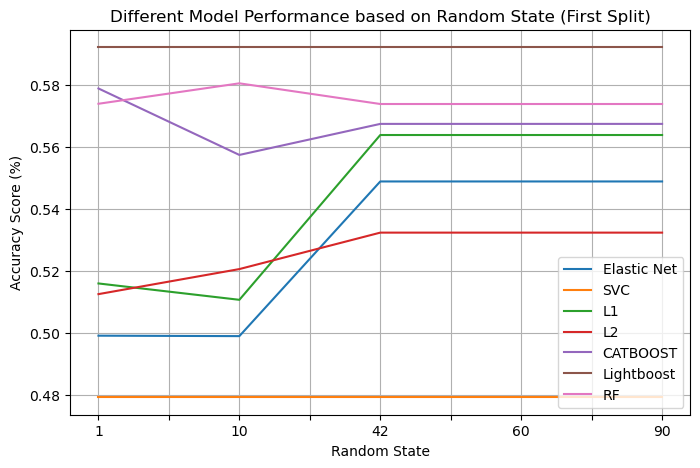

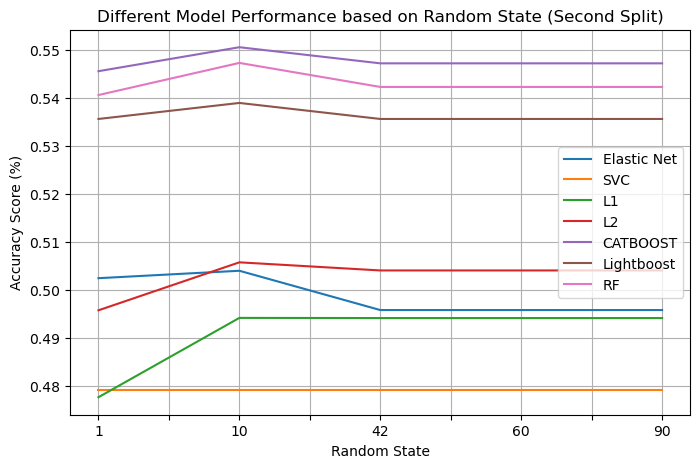

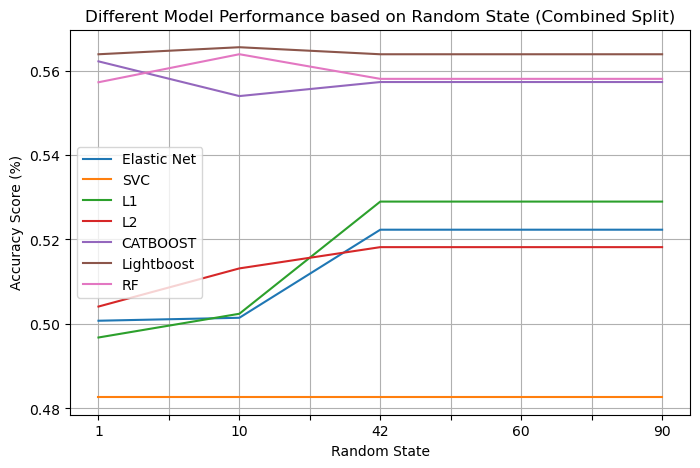

In [206]:
all_rs1.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rs2.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_rsc.T.plot(figsize=(8,5), grid=True)
plt.xlabel('Random State')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on Random State (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on Random State (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


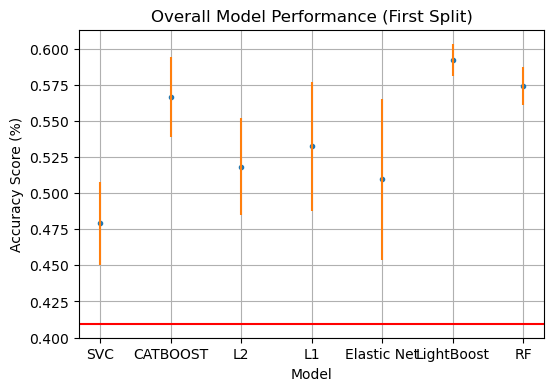

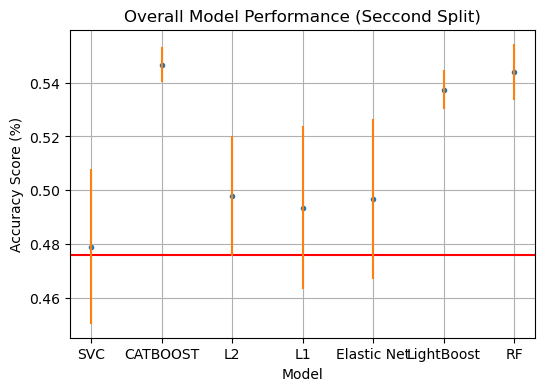

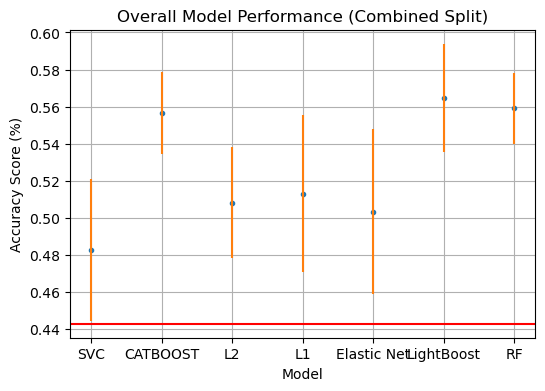

In [208]:
model_stat_split1['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.axhline(y=(stat.mean(baseline_df['Split 1'].to_list())), color='r', linestyle='-')
plt.xlabel('Model')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (First Split)')
plt.errorbar(model_stat_split1.index, model_stat_split1['Mean'], yerr=model_stat_split1['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - First Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_split2['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.xlabel('Model')
plt.axhline(y=(stat.mean(baseline_df['Split 2'].to_list())), color='r', linestyle='-')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Seccond Split)')
plt.errorbar(model_stat_split2.index, model_stat_split2['Mean'], yerr=model_stat_split2['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - Second Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

model_stat_splitc['Mean'].plot(figsize=(6,4), grid=True,ls = 'none', marker = '.')
plt.xlabel('Model')
plt.axhline(y=0.4427692575810387, color='r', linestyle='-')
plt.ylabel('Accuracy Score (%)')
plt.title('Overall Model Performance (Combined Split)')
plt.errorbar(model_stat_splitc.index, model_stat_splitc['Mean'], yerr=model_stat_splitc['STD'], ls = 'none')
plt.savefig(fname = '../figures/Overall Model Performance - Combined Split', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


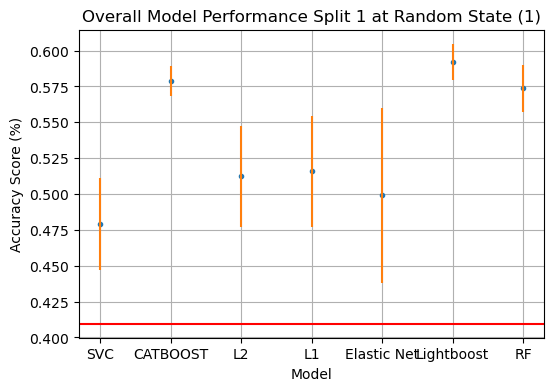

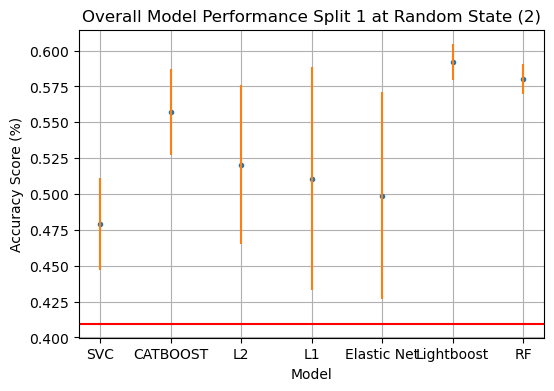

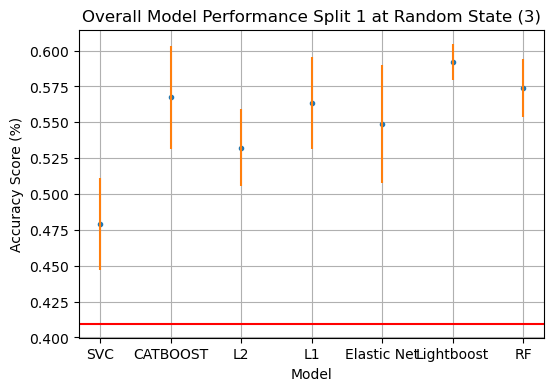

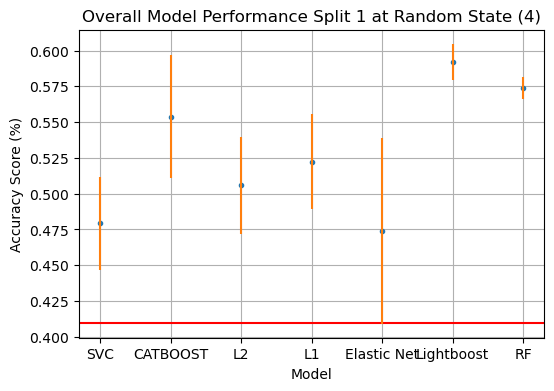

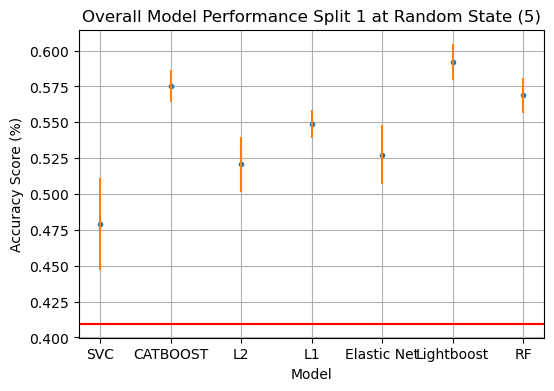

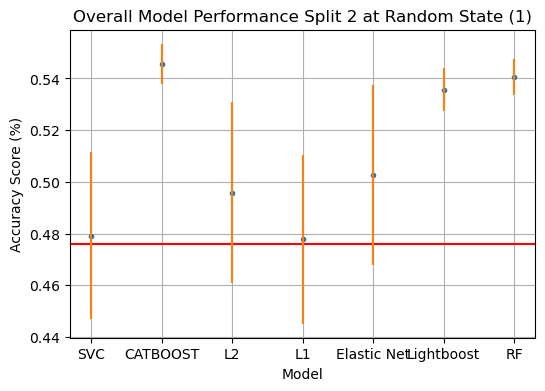

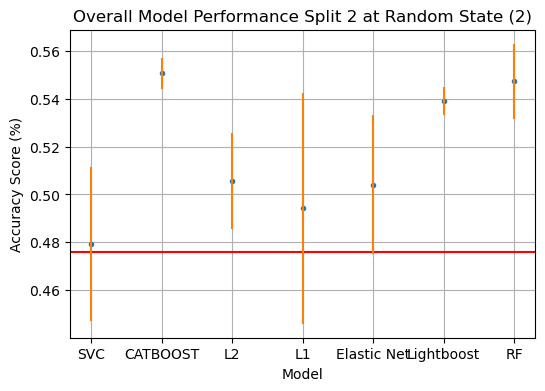

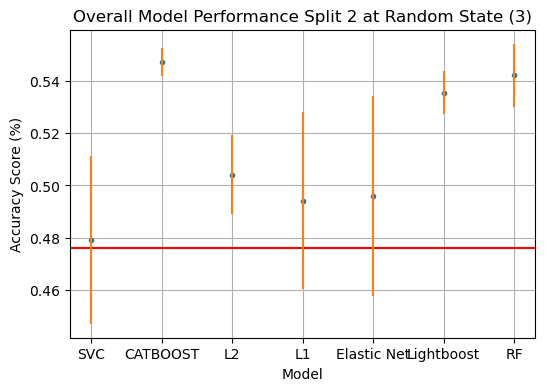

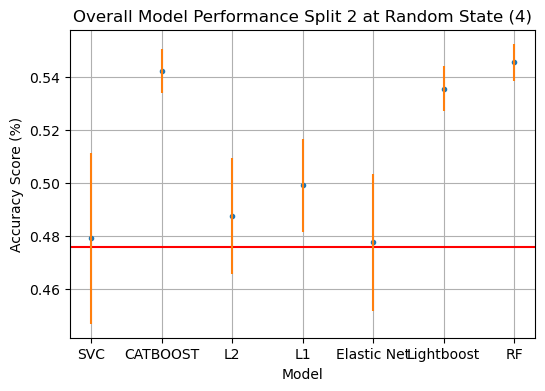

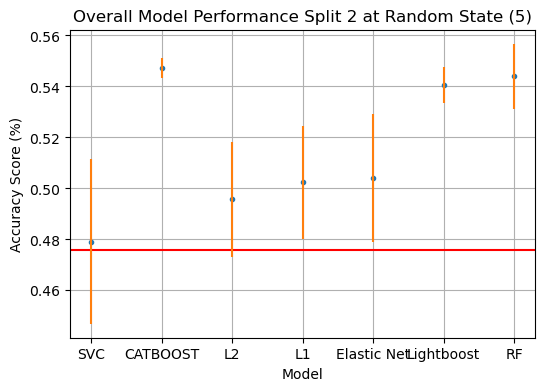

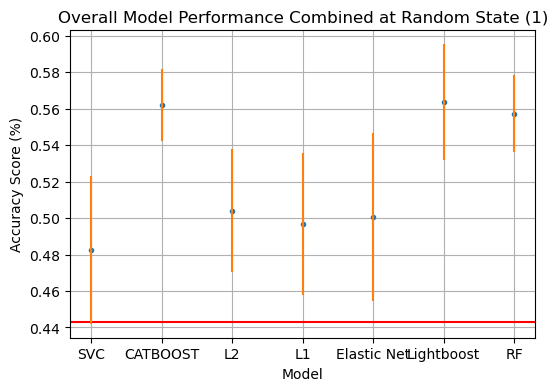

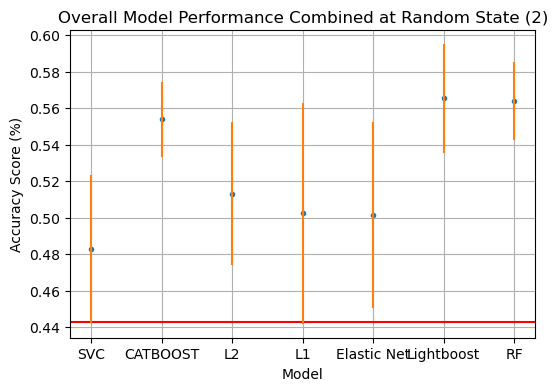

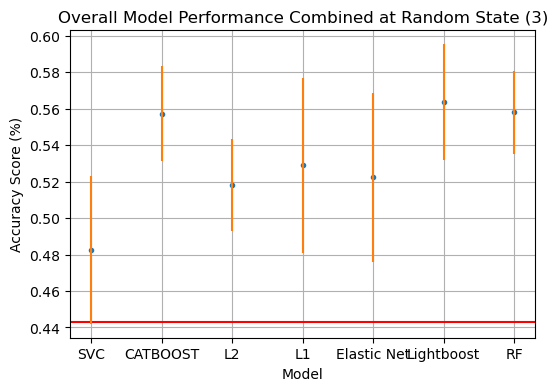

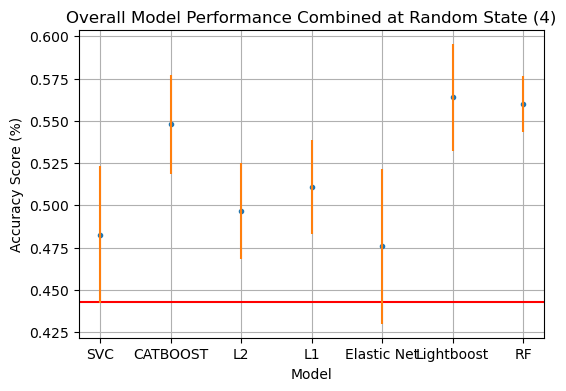

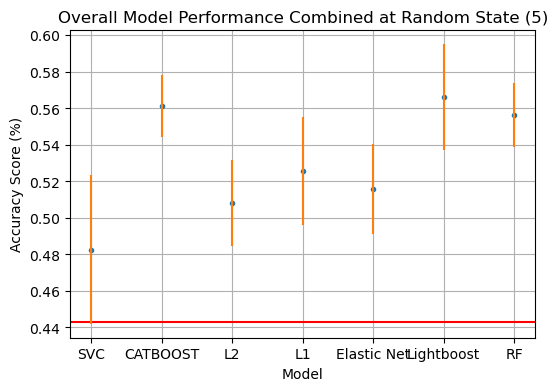

In [299]:
def plot_rs(df, rs, baseline, types):
    df['Mean'].plot(figsize=(6,4), grid=True,linestyle='None', marker = ".")
    plt.axhline(y=(stat.mean(baseline)), color='r', linestyle='-')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score (%)')
    plt.title('Overall Model Performance {} at Random State ({})'.format(types, rs))
    plt.errorbar(df.index, df['Mean'], yerr=df['STD'], ls='none')
    plt.savefig(fname = '../figures/Overall Model Performance - {} Split at Random State ({})'.format(types, rs), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    

plot_rs(model_stat_split1rs1, 1,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs2, 2,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs3, 3,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs4, 4,baseline_df['Split 1'].to_list(),'Split 1')
plot_rs(model_stat_split1rs5, 5,baseline_df['Split 1'].to_list(),'Split 1')
                
plot_rs(model_stat_split2rs1, 1,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs2, 2,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs3, 3,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs4, 4,baseline_df['Split 2'].to_list(),'Split 2')
plot_rs(model_stat_split2rs5, 5,baseline_df['Split 2'].to_list(),'Split 2')

                
plot_rs(model_stat_splitcrs1, 1,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs2, 2,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs3, 3,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs4, 4,baseline_df['Combined'].to_list(),'Combined')
plot_rs(model_stat_splitcrs5, 5,baseline_df['Combined'].to_list(),'Combined')


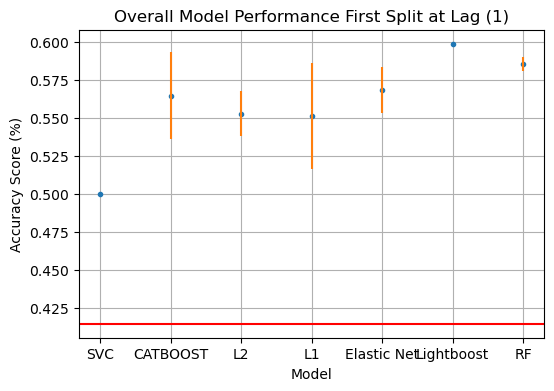

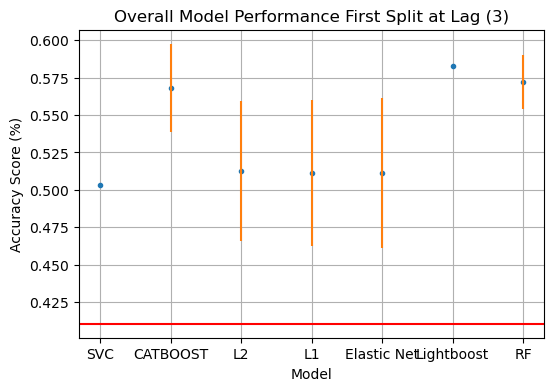

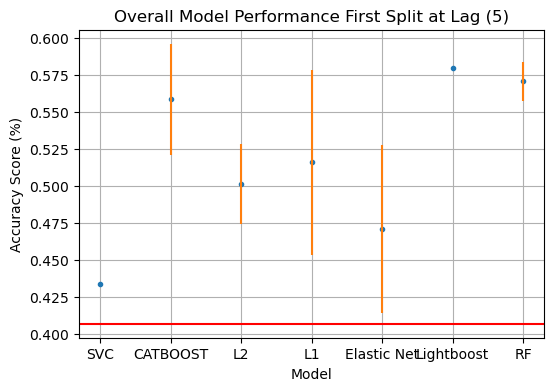

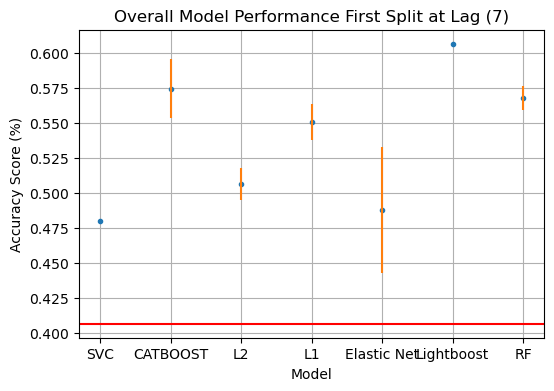

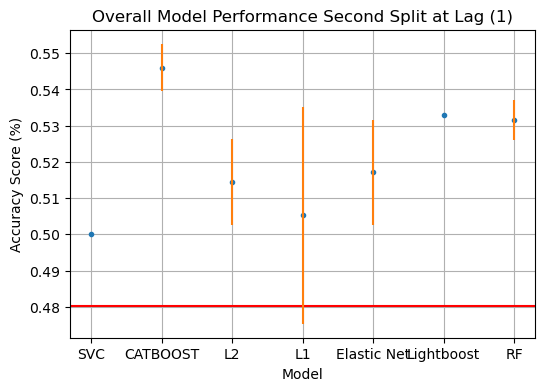

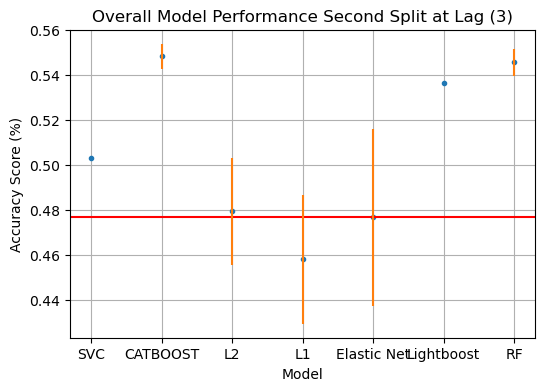

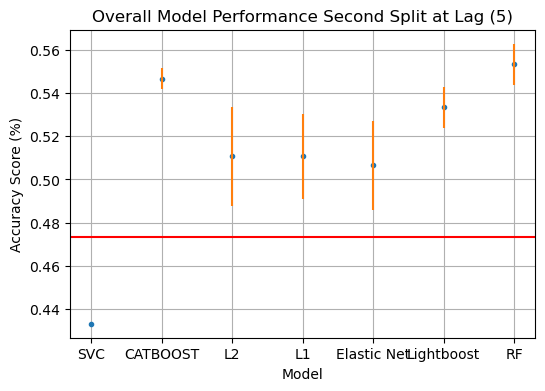

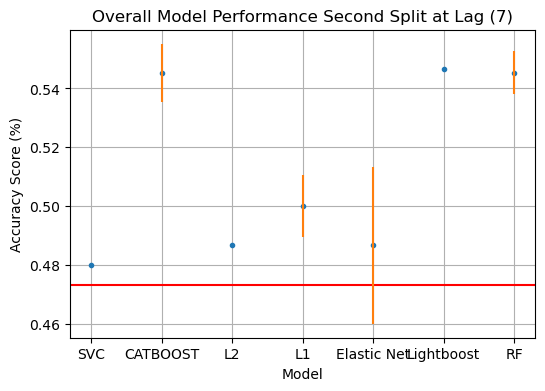

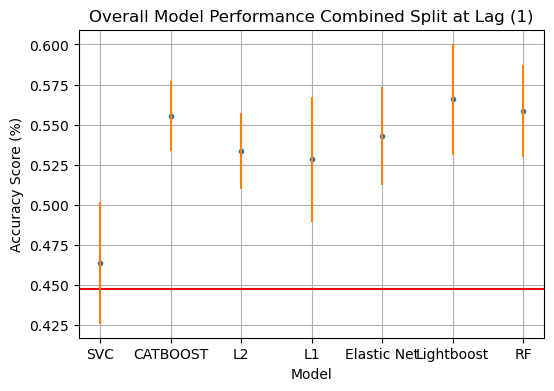

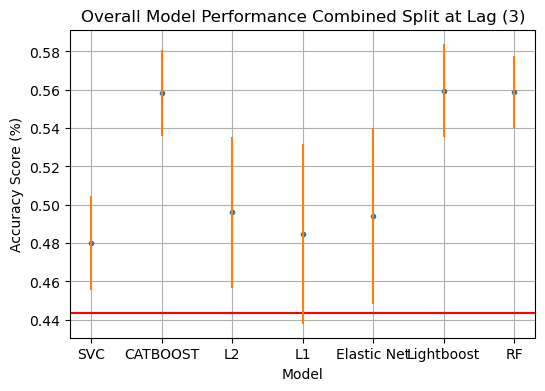

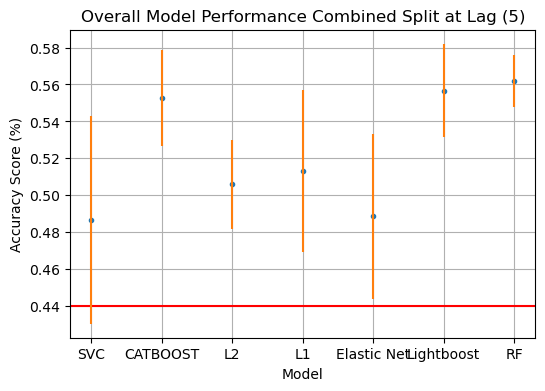

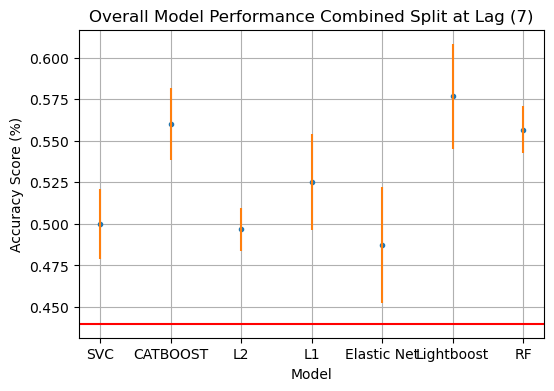

In [229]:
def plot_lag(df, split, lag, baseline):
    df['Mean'].plot(figsize=(6,4), grid=True,linestyle='None', marker = ".")
    plt.axhline(y=baseline, color='r', linestyle='-')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score (%)')
    plt.title('Overall Model Performance {} Split at Lag ({})'.format(split, lag))
    plt.errorbar(df.index, df['Mean'], yerr=df['STD'], ls='none')
    plt.savefig(fname = '../figures/Overall Model Performance - {} Split at Lag ({})'.format(split, lag), format = 'png', dpi = 300, bbox_inches='tight')
    plt.show()
    

plot_lag(model_stat_split1_lag1, 'First', 1, baseline_df['Split 1']['Lag 1'])
plot_lag(model_stat_split1_lag3, 'First', 3, baseline_df['Split 1']['Lag 3'])
plot_lag(model_stat_split1_lag5, 'First',5, baseline_df['Split 1']['Lag 5'])
plot_lag(model_stat_split1_lag7, 'First',7,baseline_df['Split 1']['Lag 7'])

plot_lag(model_stat_split2_lag1, 'Second',1,baseline_df['Split 2']['Lag 1'])
plot_lag(model_stat_split2_lag3, 'Second',3,baseline_df['Split 2']['Lag 3'])
plot_lag(model_stat_split2_lag5, 'Second',5,baseline_df['Split 2']['Lag 5'])
plot_lag(model_stat_split2_lag7, 'Second',7,baseline_df['Split 2']['Lag 7'])

plot_lag(model_stat_splitc_lag1,'Combined', 1,baseline_df['Combined']['Lag 1'])
plot_lag(model_stat_splitc_lag3,'Combined', 3,baseline_df['Combined']['Lag 3'])
plot_lag(model_stat_splitc_lag5,'Combined', 5,baseline_df['Combined']['Lag 5'])
plot_lag(model_stat_splitc_lag7,'Combined', 7,baseline_df['Combined']['Lag 7'])



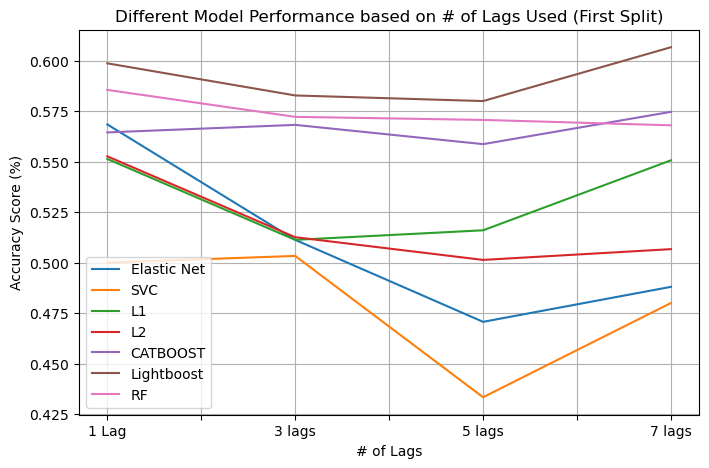

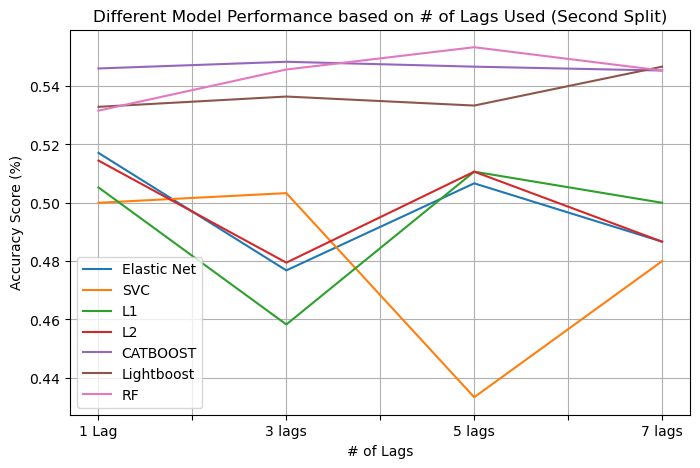

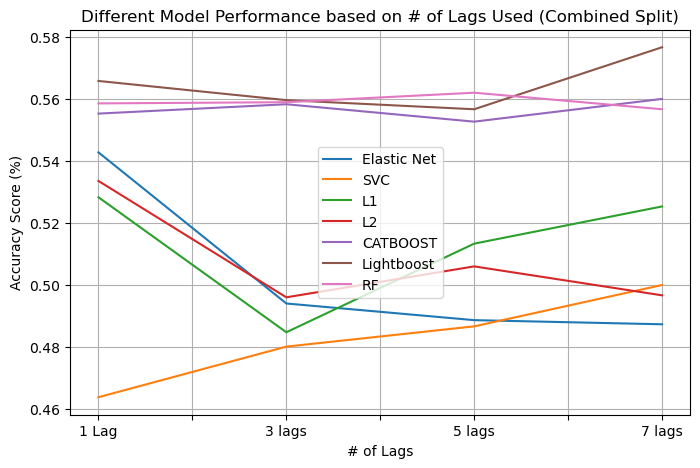

In [205]:
all_lags1.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (First Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (First Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lags2.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Second Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Second Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()

all_lagsc.T.plot(figsize=(8,5), grid=True)
plt.xlabel('# of Lags')
plt.ylabel('Accuracy Score (%)')
plt.title('Different Model Performance based on # of Lags Used (Combined Split)')
plt.savefig(fname = '../figures/Different Model Performance based on # of Lags Used (Combined Split)', format = 'png', dpi = 300, bbox_inches='tight')
plt.show()


## Results - Tables

In [230]:
top_models.iloc[:10]

Model Type    Lag     Score  RS  Split
0  Lightboost  Lag 7  0.606667   1      1
1  Lightboost  Lag 7  0.606667   2      1
2  Lightboost  Lag 7  0.606667   3      1
3  Lightboost  Lag 7  0.606667   4      1
4    CATBOOST  Lag 7  0.606667   3      1
5  Lightboost  Lag 7  0.606667   5      1
6  Lightboost  Lag 1  0.598684   3      1
7  Lightboost  Lag 1  0.598684   5      1
8  Lightboost  Lag 1  0.598684   4      1
9  Lightboost  Lag 1  0.598684   2      1

In [231]:
top_models.iloc[-10:]

Model Type    Lag     Score  RS  Split
270          SVC  Lag 5  0.433333   3      1
271          SVC  Lag 1  0.427632   5      2
272          SVC  Lag 1  0.427632   4      2
273          SVC  Lag 1  0.427632   3      2
274          SVC  Lag 1  0.427632   2      2
275          SVC  Lag 1  0.427632   1      2
276           L1  Lag 3  0.423841   2      2
277  Elastic Net  Lag 7  0.413333   4      1
278  Elastic Net  Lag 5  0.406667   2      1
279           L1  Lag 5  0.406667   2      1

In [232]:
baseline_df

Split 1   Split 2  Combined       STD
Lag 1  0.414474  0.480263  0.447368  0.046520
Lag 3  0.410596  0.476821  0.443709  0.046828
Lag 5  0.406667  0.473333  0.440000  0.047140
Lag 7  0.406667  0.473333  0.440000  0.047140

In [393]:
model_stat_split2[['Mean', 'STD']]

Mean   STD
SVC         0.479 0.029
CATBOOST    0.547 0.006
L2          0.498 0.022
L1          0.494 0.030
Elastic Net 0.497 0.030
LightBoost  0.537 0.007
RF          0.544 0.010

In [305]:
updatedpdlag11

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  \
Elastic Net       0.568      0.015       0.511      0.050       0.471   
SVC               0.500      0.000       0.503      0.000       0.433   
L1                0.551      0.035       0.511      0.049       0.516   
L2                0.553      0.015       0.513      0.047       0.501   
CATBOOST          0.564      0.028       0.568      0.029       0.559   
Lightboost        0.599      0.000       0.583      0.000       0.580   
RF                0.586      0.005       0.572      0.018       0.571   

             5 Lag STD  7 Lag Mean  7 Lag STD  
Elastic Net      0.057       0.488      0.045  
SVC              0.000       0.480      0.000  
L1               0.063       0.551      0.013  
L2               0.027       0.507      0.012  
CATBOOST         0.038       0.575      0.021  
Lightboost       0.000       0.607      0.000  
RF               0.013       0.568      0.009

In [306]:
updatedpdlag12

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  \
Elastic Net       0.517      0.014       0.477      0.039       0.507   
SVC               0.500      0.000       0.503      0.000       0.433   
L1                0.505      0.030       0.458      0.029       0.511   
L2                0.514      0.012       0.479      0.024       0.511   
CATBOOST          0.546      0.007       0.548      0.006       0.547   
Lightboost        0.533      0.000       0.536      0.000       0.533   
RF                0.532      0.006       0.546      0.006       0.553   

             5 Lag STD  7 Lag Mean  7 Lag STD  
Elastic Net      0.021       0.487      0.027  
SVC              0.000       0.480      0.000  
L1               0.020       0.500      0.011  
L2               0.023       0.487      0.000  
CATBOOST         0.005       0.545      0.010  
Lightboost       0.009       0.547      0.000  
RF               0.009       0.545      0.007

In [307]:
updatedpdlagc = updatedpdlag1
updatedpdlagc

1 Lag Mean  1 Lag STD  3 Lag Mean  3 Lag STD  5 Lag Mean  \
Elastic Net       0.543      0.030       0.494      0.046       0.489   
SVC               0.464      0.038       0.480      0.024       0.487   
L1                0.528      0.039       0.485      0.047       0.513   
L2                0.534      0.024       0.496      0.039       0.506   
CATBOOST          0.555      0.022       0.558      0.023       0.553   
Lightboost        0.566      0.035       0.560      0.024       0.557   
RF                0.559      0.029       0.559      0.019       0.562   

             5 Lag STD  7 Lag Mean  7 Lag STD  
Elastic Net      0.045       0.487      0.035  
SVC              0.056       0.500      0.021  
L1               0.044       0.525      0.029  
L2               0.024       0.497      0.013  
CATBOOST         0.026       0.560      0.022  
Lightboost       0.025       0.577      0.032  
RF               0.014       0.557      0.014

In [325]:
zscores_by_lags[['1 Lag zscore','3 Lag zscore','5 Lag zscore','7 Lag zscore']]

1 Lag zscore  3 Lag zscore  5 Lag zscore  7 Lag zscore
Elastic Net         2.051         1.075         1.032         1.004
SVC                 0.354         0.778         0.990         1.273
L1                  1.739         0.877         1.556         1.810
L2                  1.853         1.117         1.400         1.202
CATBOOST            2.319         2.447         2.390         2.546
Lightboost          2.546         2.475         2.475         2.899
RF                  2.390         2.461         2.588         2.475

In [309]:
model_stat_split1.sort_values('Mean', ascending = False)

Mean   STD   SEM
LightBoost  0.592 0.011 0.003
RF          0.574 0.013 0.003
CATBOOST    0.567 0.028 0.006
L1          0.532 0.045 0.010
L2          0.518 0.033 0.007
Elastic Net 0.510 0.056 0.012
SVC         0.479 0.029 0.006

In [313]:
model_stat_split2.sort_values('Mean', ascending = False)

Mean   STD   SEM
CATBOOST    0.547 0.006 0.001
RF          0.544 0.010 0.002
LightBoost  0.537 0.007 0.002
L2          0.498 0.022 0.005
Elastic Net 0.497 0.030 0.007
L1          0.494 0.030 0.007
SVC         0.479 0.029 0.006

## Best Model

In [333]:
tscv = TimeSeriesSplit(2)
best_modellgb7 = []
best_scorelgb7 = []
cmlgb7 = []
feature_nameslgb7 = []

param_grid = {'ml__colsample_bytree': [0.99], 
 'ml__max_depth': [40], 
 'ml__min_child_samples':[20],
 'ml__min_child_weight': [1e-05], 
 'ml__n_estimators': [5],
 'ml__num_leaves': [3],
 'ml__random_state': [60]}

X =X7_lagged
y = y7_lagged

counter = 0

for train_index, test_index in tscv.split(X):
    if counter == 1:
        break
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pipe = Pipeline(steps=[('preprocessor', preprocessor_7), ('ml', LGGclass)])
    gsearch = GridSearchCV(pipe, cv=tscv, param_grid= param_grid, scoring = 'f1_micro', refit = 'f1_micro')
    gsearch.fit(X_train, y_train) 

    best_model = gsearch.best_estimator_
    best_score = gsearch.best_score_
    best_param = gsearch.best_params_
    feature_nameslgb7 = best_model[:-1].get_feature_names_out()

    y_pred = best_model.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    best_scorelgb7.append(test_score)
    cmlgb7.append(confusion_matrix(y_test,y_pred))
    best_modellgb7.append(best_model)
    
    print('\nConfusion Matrix\n')
    print(confusion_matrix(y_test,y_pred))

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))
    counter += 1


Confusion Matrix

[[34  0 25]
 [10  2 18]
 [ 6  0 55]]

Accuracy: 0.61

Micro Precision: 0.61
Micro Recall: 0.61
Micro F1-score: 0.61

Macro Precision: 0.75
Macro Recall: 0.51
Macro F1-score: 0.48

Weighted Precision: 0.70
Weighted Recall: 0.61
Weighted F1-score: 0.55

Classification Report

              precision    recall  f1-score   support

     Class 1       0.68      0.58      0.62        59
     Class 2       1.00      0.07      0.12        30
     Class 3       0.56      0.90      0.69        61

    accuracy                           0.61       150
   macro avg       0.75      0.51      0.48       150
weighted avg       0.70      0.61      0.55       150



In [392]:
print(f'Baseline Score at 7 Lags: {0.406667:.3f}')
print(f'Lightboost Score (7 Lags - First Split - 60 RS): {best_scorelgb7[0]:.3f}')

print('Overall Lightboost Mean:', 0.564681)
print('Overall Lightboost STD:', round(stat.stdev(top_models.loc[top_models['Model Type'] == 'Lightboost']['Score'].to_list()),4)
)

print('Overall Baseline Mean:', round(mean_all_baselines,4))
print('Overall Baseline STD:', round(std_all_baselines,4))

print('Lightboost zscore (overall):' ,3.613937)
print('Lightboost zscore (at Lag 7):' ,2.899166)


Baseline Score at 7 Lags: 0.407
Lightboost Score (7 Lags - First Split - 60 RS): 0.607
Overall Lightboost Mean: 0.564681
Overall Lightboost STD: 0.0292
Overall Baseline Mean: 0.4428
Overall Baseline STD: 0.0337
Lightboost zscore (overall): 3.613937
Lightboost zscore (at Lag 7): 2.899166


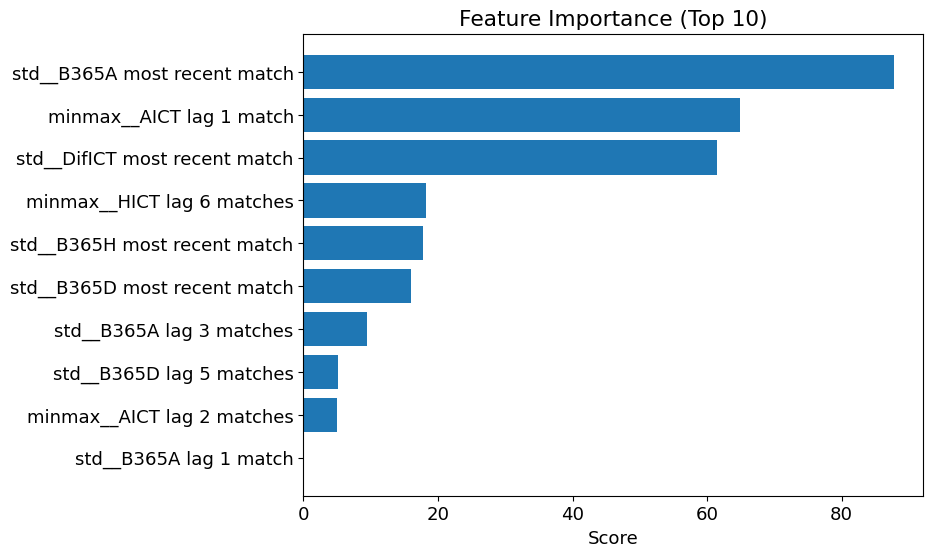

In [386]:
overall_best_model = best_modellgb7[0][1]
feature_values = best_modellgb7[0][0].transform(X7_lagged)
lgb7_matrix = pd.DataFrame(data=feature_values,columns=feature_nameslgb7)
feature_importance = overall_best_model.booster_.feature_importance(importance_type = 'gain')

sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx[-10:])), feature_importance[sorted_idx][-10:], align='center')
plt.yticks(range(len(sorted_idx[-10:])), np.array(feature_nameslgb7)[sorted_idx][-10:])
plt.title('Feature Importance (Top 10)')
plt.xlabel("Score")
plt.show()

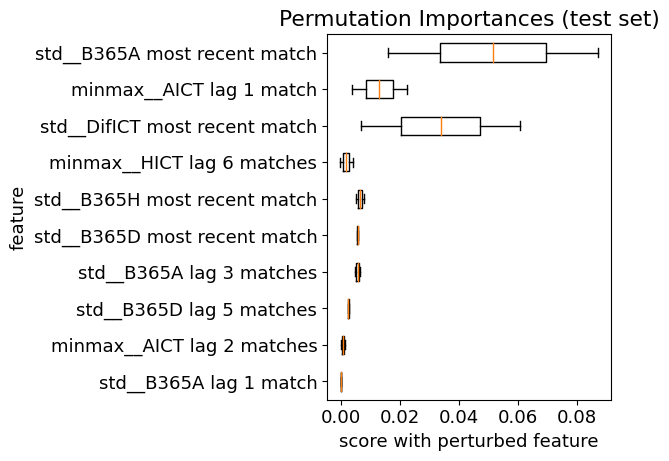

In [391]:
from sklearn.inspection import permutation_importance

features_mean =perm_importance.importances_mean[sorted_idx][-10:]
features_std = perm_importance.importances_std[sorted_idx][-10:]
feature_names_perb =np.array(feature_nameslgb7)[sorted_idx][-10:]
df_perb = pd.DataFrame(features_mean.T,feature_names_perb)
df_perb['STD'] = features_std


plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(df_perb.T, labels=df_perb.T.columns,vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.ylabel('feature')

plt.tight_layout()
plt.show()


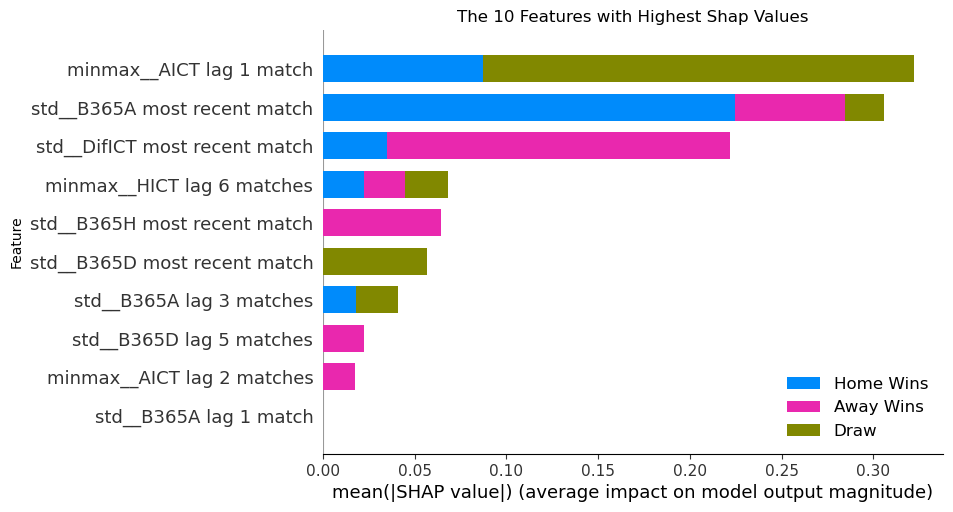

In [334]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(overall_best_model)
shap_values = explainer.shap_values(feature_values)
plt.title("The 10 Features with Highest Shap Values")
plt.ylabel("Feature")
shap.summary_plot(shap_values, lgb7_matrix, max_display = 10, class_names= ['Away Wins', 'Draw', 'Home Wins'])


In [369]:
#forceplot1 - win
index = 30 # the index of the point to explain
print(explainer.expected_value[2]) # we explain class 2 predictions
shap.force_plot(explainer.expected_value[2], shap_values[2][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)



-0.8895917009287115


In [140]:
#forceplot2 - draw
index = 42 # the index of the point to explain
print(explainer.expected_value[1]) # we explain class 1 predictions
shap.force_plot(explainer.expected_value[1], shap_values[1][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)
plt.savefig(fname = '../figures/Force Plot - Draw', format = 'png', dpi = 300, bbox_inches='tight')


-1.3109534678062458


In [141]:
#forceplot3 - loss
index = 4 # the index of the point to explain
print(explainer.expected_value[0]) # we explain class 0 predictions
shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = feature_values[index,:],feature_names = lgb7_matrix.columns)
plt.savefig(fname = '../figures/Force Plot - Loss', format = 'png', dpi = 300, bbox_inches='tight')





-1.1769460650713428


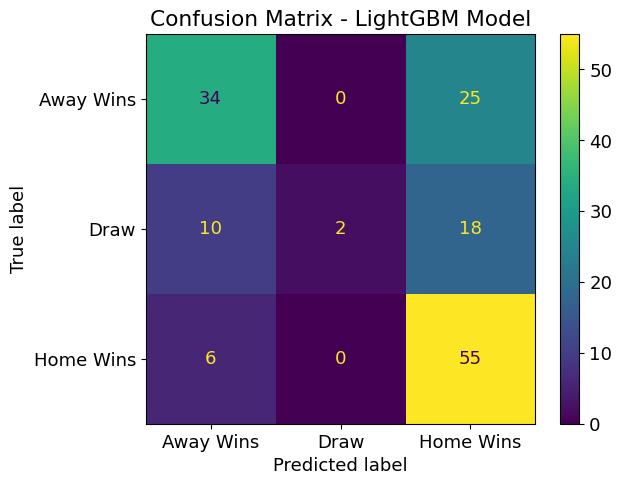

In [371]:
disp = ConfusionMatrixDisplay(cmlgb7[0],display_labels=['Away Wins', 'Draw', 'Home Wins'])
disp.plot()
plt.tight_layout()
plt.title('Confusion Matrix - LightGBM Model')
plt.show() 